# Project Four: Part Three

### Import Packages

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import xlrd
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest
from sklearn.metrics import r2_score
from pmdarima.arima import ndiffs
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot, lag_plot
import warnings
warnings.filterwarnings('ignore')
import itertools
import statsmodels.api as sm
from matplotlib.pylab import rcParams
plt.style.use('ggplot')
from statsmodels.tsa.stattools import adfuller


### Open Pickled Dataframe

In [11]:
kings_grouped = pd.read_pickle("./kings_grouped.pkl")

### ACF PACF Function

In [12]:
# acf and pacf function

def plot_acf_pacf(ts, figsize=(10,8), lags = 24, zipcode = 'add'):
    
    fig,ax = plt.subplots(nrows=3,
                         figsize = figsize)
    
    #plot time series
    ts.plot(ax=ax[0])
    
    #plot acf, pacf
    plot_acf(ts,ax=ax[1], lags=lags)
    plot_pacf(ts, ax=ax[2], lags=lags)
    fig.tight_layout()
    
    fig.suptitle(f'Zipcode: {zipcode}',y=1.1, fontsize=20)
    
    for a in ax[1:]:
        a.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(min_n_ticks=lags, integer = True))
        a.xaxis.grid()
    return fig,ax

### 11233

In [13]:
two_three_three = kings_grouped.loc[11233]

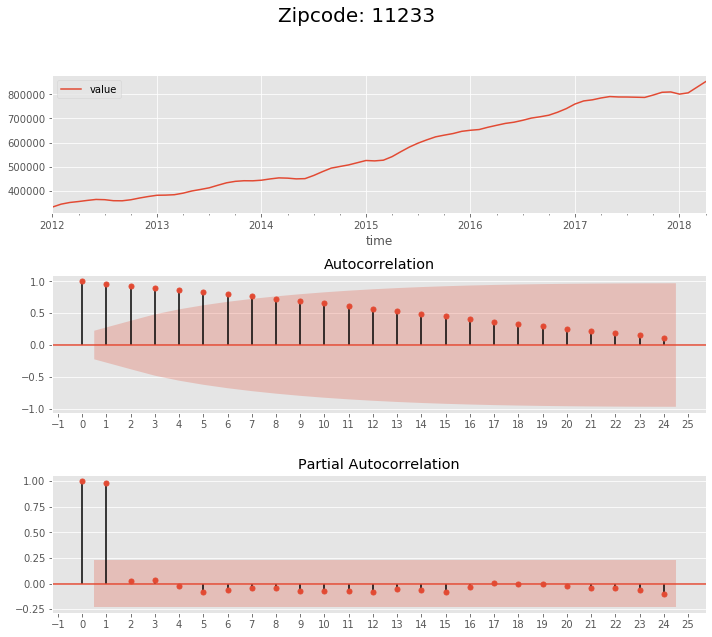

In [14]:
plot_acf_pacf(two_three_three, zipcode = '11233')
plt.show()

### Decompose Time Series

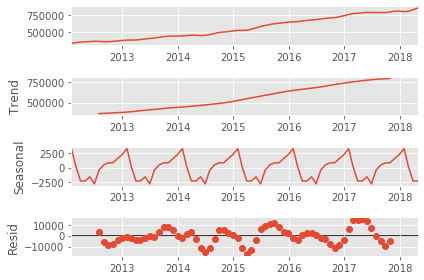

In [15]:
decompose_result = seasonal_decompose(two_three_three, model="additive")

trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

decompose_result.plot();

### Fixing Trend: Moving Window Function (Mean Rolled)

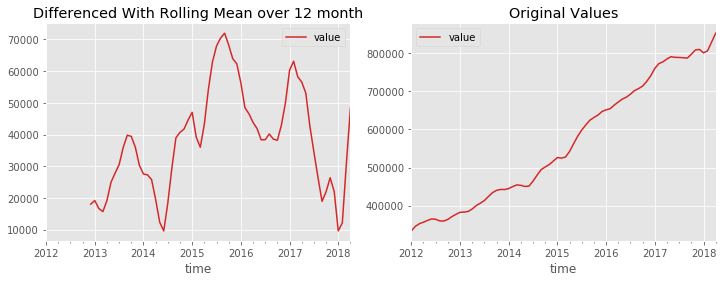

In [17]:
rolling_mean = two_three_three.rolling(window = 12).mean()
two_three_three_rolled_detrended = two_three_three - rolling_mean

ax1 = plt.subplot(121)
two_three_three_rolled_detrended.plot(figsize=(12,4),color="tab:red", title="Differenced With Rolling Mean over 12 month", ax=ax1);
ax2 = plt.subplot(122)
two_three_three.plot(figsize=(12,4), color="tab:red", title="Original Values", ax=ax2);

### Testing with the Dicky-Fuller Test

Stationarity is not present.

In [18]:
dftest = adfuller(two_three_three_rolled_detrended.dropna(), autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -3.034783869042049
2. P-Value :  0.03177125136087184
3. Num Of Lags :  3
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 61
5. Critical Values :
	 1% :  -3.542412746661615
	 5% :  -2.910236235808284
	 10% :  -2.5927445767266866


In [27]:
two_three_three = two_three_three_rolled_detrended.dropna()

### Parameter Selection

In [28]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [29]:
# Run a grid with pdq and seasonal pdq parameters 
#calculated above and get the best (lowest) AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(two_three_three, 
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            #print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

In [30]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic           765.829
Name: 59, dtype: object

### Fitting the Time Series Model - ARIMA

In [31]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(two_three_three, 
                                        order=(1, 1, 1), 
                                        seasonal_order=(0, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4091      0.272      1.505      0.132      -0.124       0.942
ma.L1          0.7216      0.188      3.834      0.000       0.353       1.091
ma.S.L12      -0.7896      0.207     -3.823      0.000      -1.194      -0.385
sigma2      3.742e+07   3.69e-09   1.01e+16      0.000    3.74e+07    3.74e+07


### Plot Diagnostics

1. top-left: Seems like random noise more than seasonality. 
2. top-right: Seems to be normally distributed.
3. bottom-left: Mostly adheres to the line.
4. bottom right: Positive values may indicate a missed seasonal component.

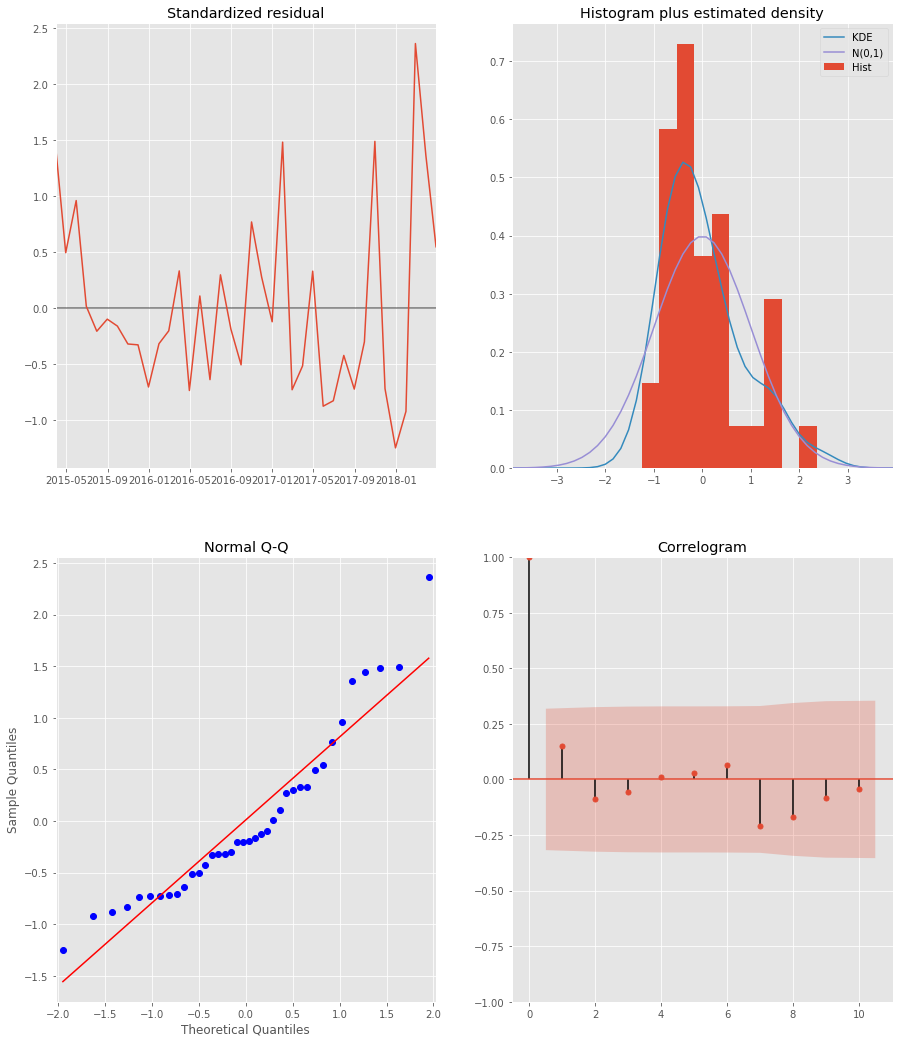

In [32]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

### Model Validation - One Step Ahead Forecasting:

The data can be split 80% and 20% by indicing at 2017-01-31.

In [33]:
pred = output.get_prediction(start=pd.to_datetime('2017-01-31'), dynamic=False)
pred_conf = pred.conf_int()

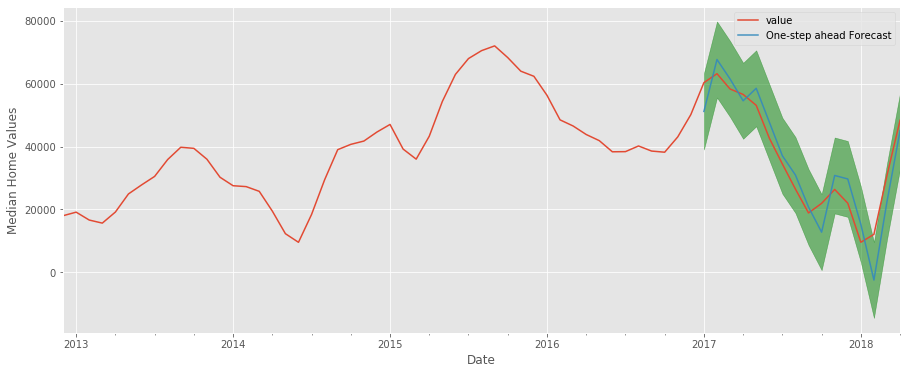

In [34]:

rcParams['figure.figsize'] = 15, 6

ax = two_three_three['2012':].plot(label='observed')

pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

ax.set_xlabel('Date')
ax.set_ylabel('Median Home Values')
plt.legend()

plt.show()

### Accuracy Validation with MSE (Mean Squared Error)

In [35]:
val_forecasted = pred.predicted_mean
val_truth = two_three_three.loc['2017-01-31':].value

mse = ((val_forecasted - val_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 43132219.81


### Model Validation - Dynamic Forecasting

In [36]:
pred_dynamic = output.get_prediction(start=pd.to_datetime('2017-01-31'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

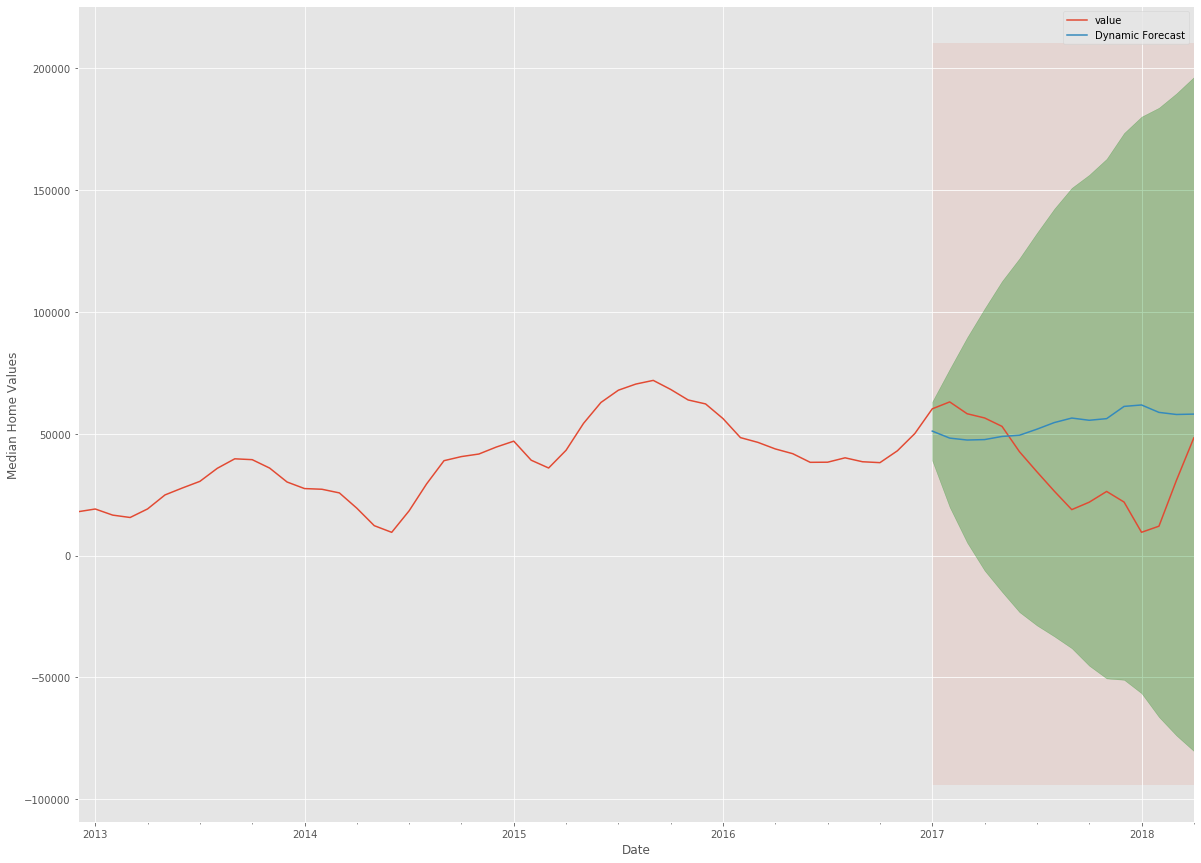

In [37]:
ax = two_three_three['2012':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2017-01-31'), val_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Median Home Values')

plt.legend()
plt.show()


In [38]:
val_forecasted = pred_dynamic.predicted_mean
val_truth = two_three_three.loc['2017-01-31':].value

mse = ((val_forecasted - val_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 774087237.62


### Visualizing Confidence Interval

In [39]:
# Get forecast 50 steps ahead in future
prediction = output.get_forecast(steps=50)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

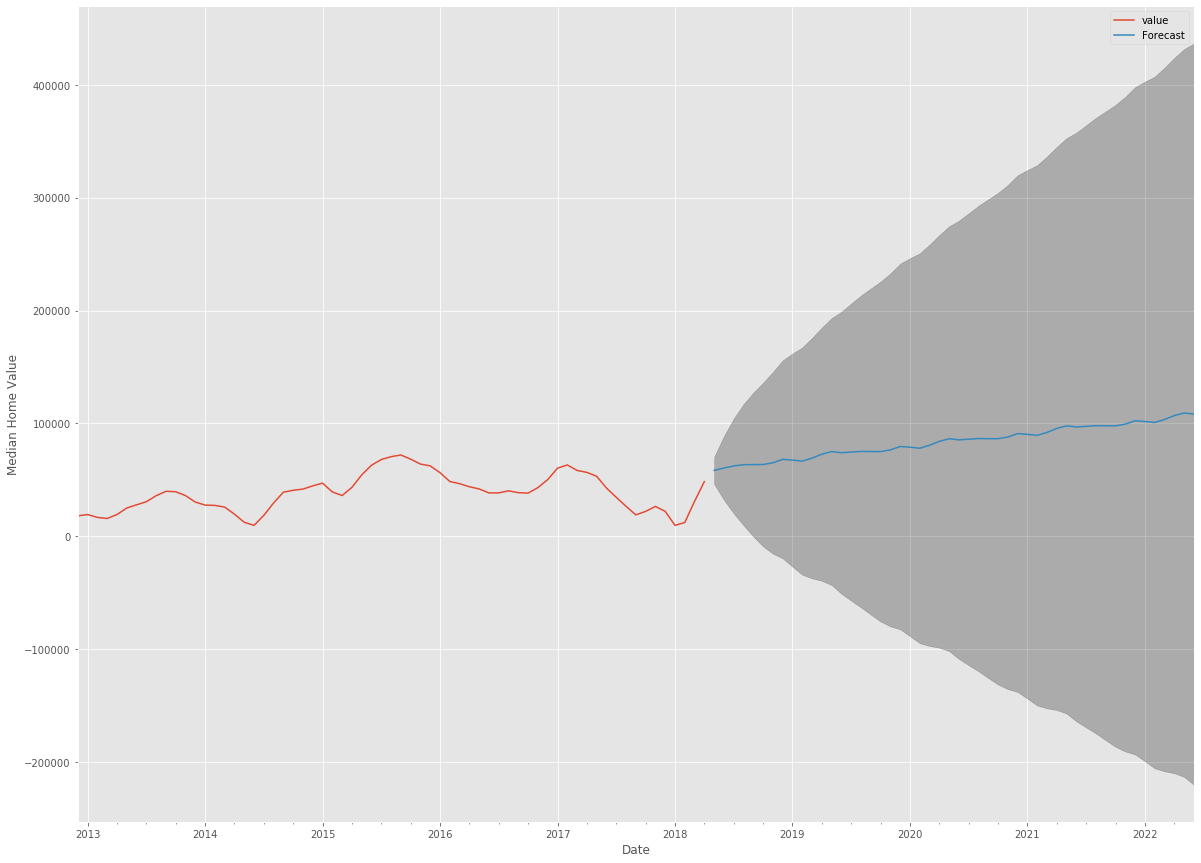

In [40]:
ax = two_three_three.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Median Home Value')

plt.legend()
plt.show()

### 11233 Conclusion: 

### 11236

In [41]:
two_three_six = kings_grouped.loc[11236]

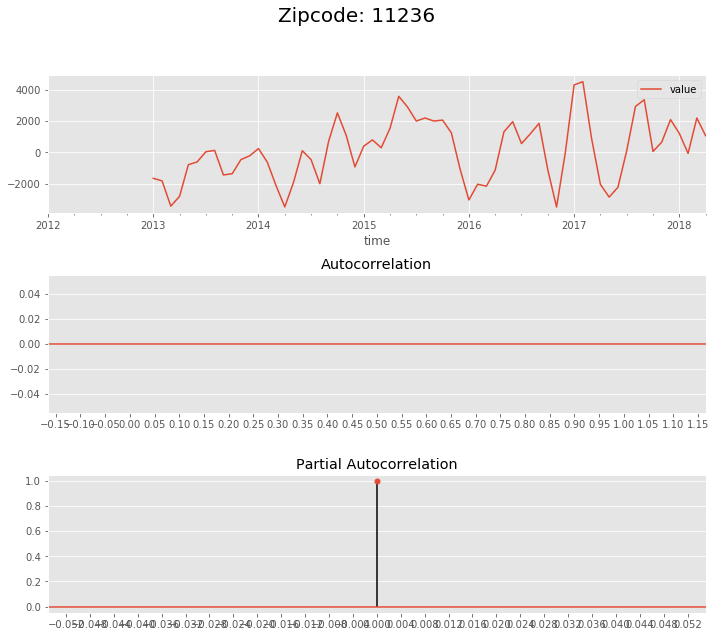

In [56]:
plot_acf_pacf(two_three_six, zipcode = '11236')
plt.show()

### Decompose Time Series

In [57]:
decompose_result = seasonal_decompose(two_three_six, model="additive")

trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

decompose_result.plot();

ValueError: This function does not handle missing values

### Fixing Trend: Moving Window Function (Mean Rolled)

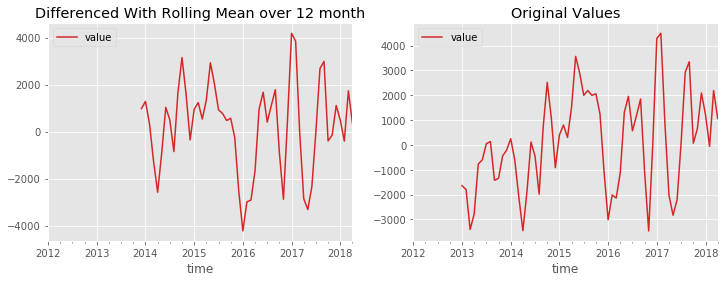

In [58]:
rolling_mean = two_three_six.rolling(window = 12).mean()
two_three_six_rolled_detrended = two_three_six - rolling_mean

ax1 = plt.subplot(121)
two_three_six_rolled_detrended.plot(figsize=(12,4),color="tab:red", title="Differenced With Rolling Mean over 12 month", ax=ax1);
ax2 = plt.subplot(122)
two_three_six.plot(figsize=(12,4), color="tab:red", title="Original Values", ax=ax2);

### Testing with the Dicky-Fuller Test

Stationarity is not present.

In [59]:
dftest = adfuller(two_three_six_rolled_detrended.dropna(), autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -3.062733847959587
2. P-Value :  0.029436814377348876
3. Num Of Lags :  6
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 46
5. Critical Values :
	 1% :  -3.5812576580093696
	 5% :  -2.9267849124681518
	 10% :  -2.6015409829867675


### Using Differencing with Mean Rolled Time Series for Seasonality

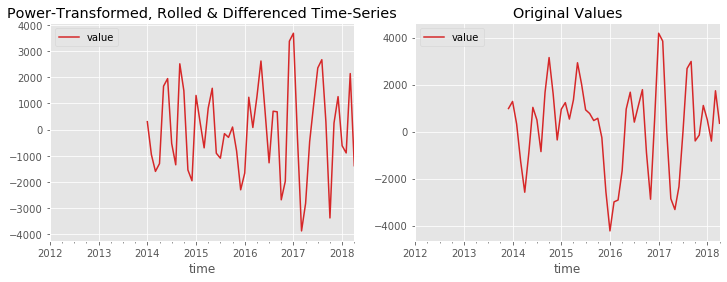

In [60]:
two_three_six_rolled_detrended_diff = two_three_six_rolled_detrended - two_three_six_rolled_detrended.shift()

ax1 = plt.subplot(121)
two_three_six_rolled_detrended_diff.plot(figsize=(8,4), color="tab:red", title="Power-Transformed, Rolled & Differenced Time-Series", ax=ax1);
ax2 = plt.subplot(122)
two_three_six_rolled_detrended.plot(figsize=(12,4), color="tab:red", title="Original Values", ax=ax2);

In [61]:
two_three_six = two_three_six_rolled_detrended_diff

### Retesting with the Dicky-Fuller Test

Technically does not have stationarity.

In [62]:
dftest = adfuller(two_three_six.dropna().values, autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -3.7857532031466112
2. P-Value :  0.00305648843550445
3. Num Of Lags :  6
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 45
5. Critical Values :
	 1% :  -3.584828853223594
	 5% :  -2.9282991495198907
	 10% :  -2.6023438271604937


### Parameter Selection

In [63]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [64]:
# Run a grid with pdq and seasonal pdq parameters 
#calculated above and get the best (lowest) AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(two_three_six, 
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            #print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

In [65]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (1, 1, 1, 12)
aic           888.894
Name: 62, dtype: object

### Fitting the Time Series Model - ARIMA

In [66]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(two_three_six, 
                                        order=(1, 1, 1), 
                                        seasonal_order=(0, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.3414     69.696      0.034      0.973    -134.260     138.943
ma.L1         -1.0328      0.244     -4.238      0.000      -1.510      -0.555
ma.S.L12    -3.87e+15      0.014  -2.76e+17      0.000   -3.87e+15   -3.87e+15
sigma2      8.926e+06   3.04e+06      2.939      0.003    2.97e+06    1.49e+07


### Plot Diagnostics

1. top-left: Seems like random noise more than seasonality. 
2. top-right: Seems to be normally distributed.
3. bottom-left: Mostly adheres to the line.
4. bottom right: Positive values may indicate a missed seasonal component.

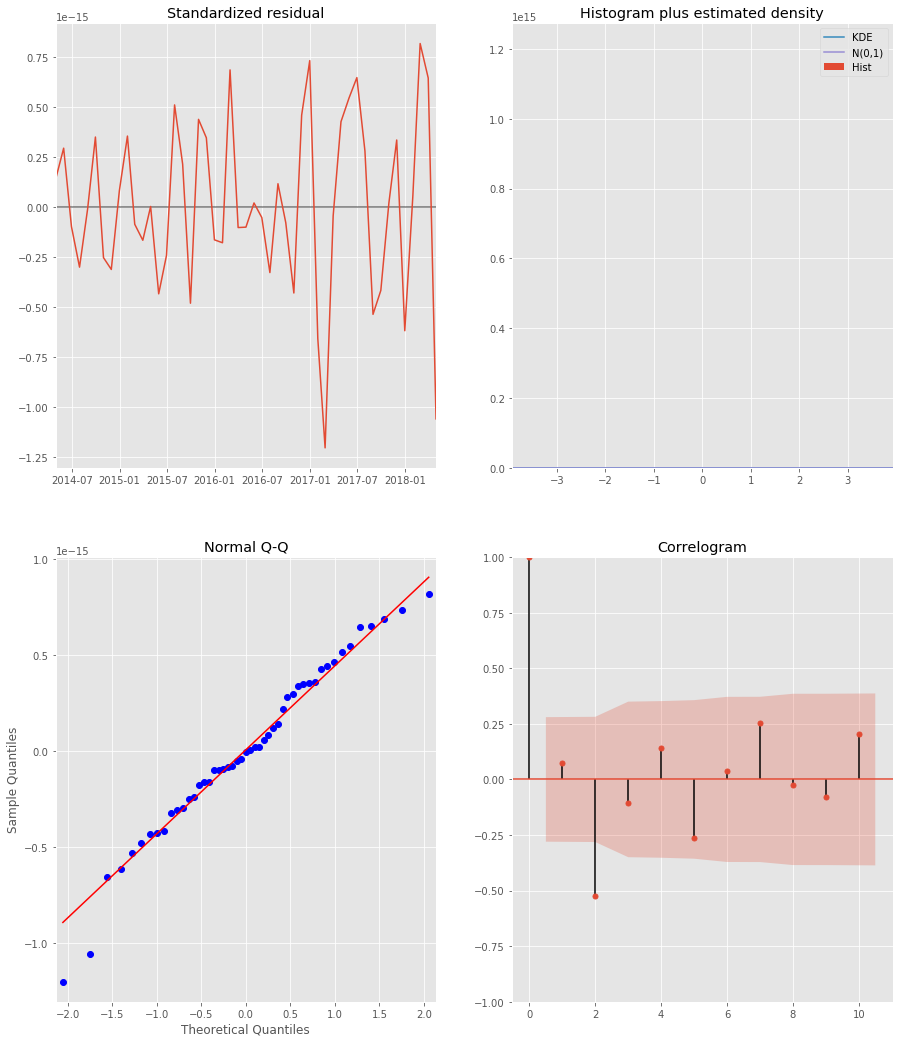

In [67]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

### Model Validation - One Step Ahead Forecasting:

The data can be split 80% and 20% by indicing at 2017-01-31.

In [68]:
pred = output.get_prediction(start=pd.to_datetime('2017-01-31'), dynamic=False)
pred_conf = pred.conf_int()

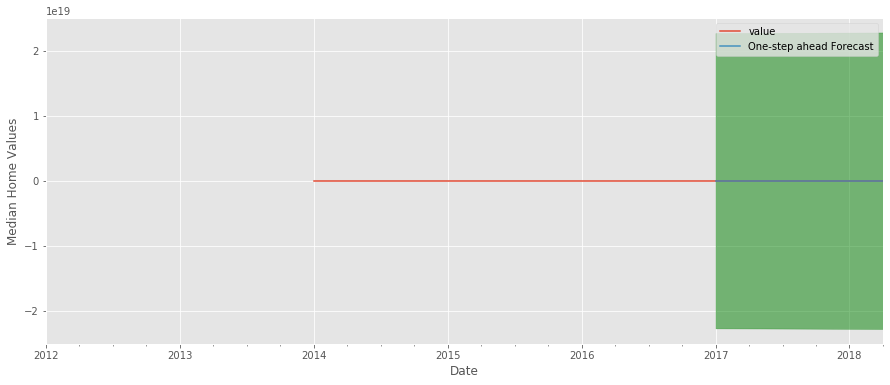

In [69]:

rcParams['figure.figsize'] = 15, 6

ax = two_three_six['2012':].plot(label='observed')

pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

ax.set_xlabel('Date')
ax.set_ylabel('Median Home Values')
plt.legend()

plt.show()

### Accuracy Validation with MSE (Mean Squared Error)

In [70]:
val_forecasted = pred.predicted_mean
val_truth = two_three_six.loc['2017-01-31':].value

mse = ((val_forecasted - val_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 50812676.64


### Model Validation - Dynamic Forecasting

In [71]:
pred_dynamic = output.get_prediction(start=pd.to_datetime('2017-01-31'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

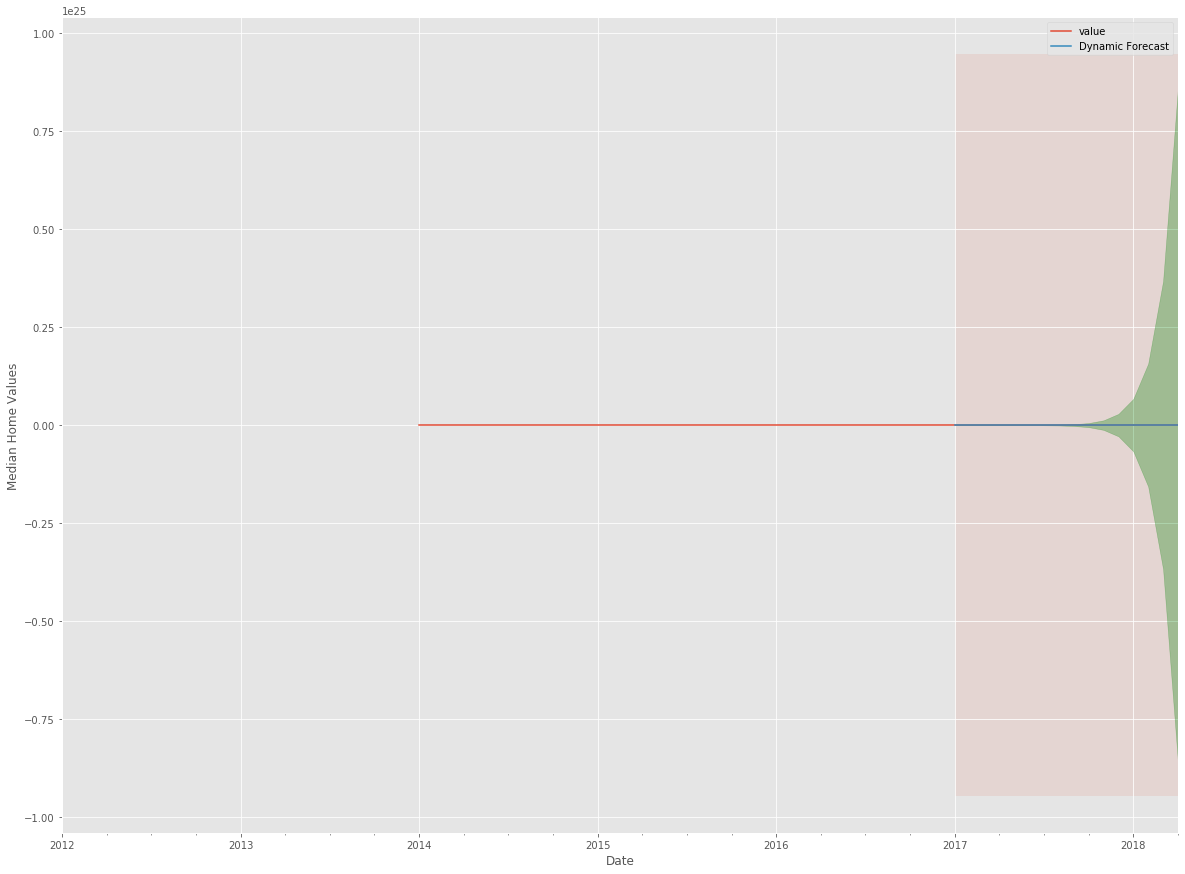

In [72]:
ax = two_three_six['2012':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2017-01-31'), val_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Median Home Values')

plt.legend()
plt.show()


In [73]:
val_forecasted = pred_dynamic.predicted_mean
val_truth = two_three_six.loc['2017-01-31':].value

mse = ((val_forecasted - val_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 1.4974241912316485e+18


### Visualizing Confidence Interval

In [74]:
# Get forecast 50 steps ahead in future
prediction = output.get_forecast(steps=50)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

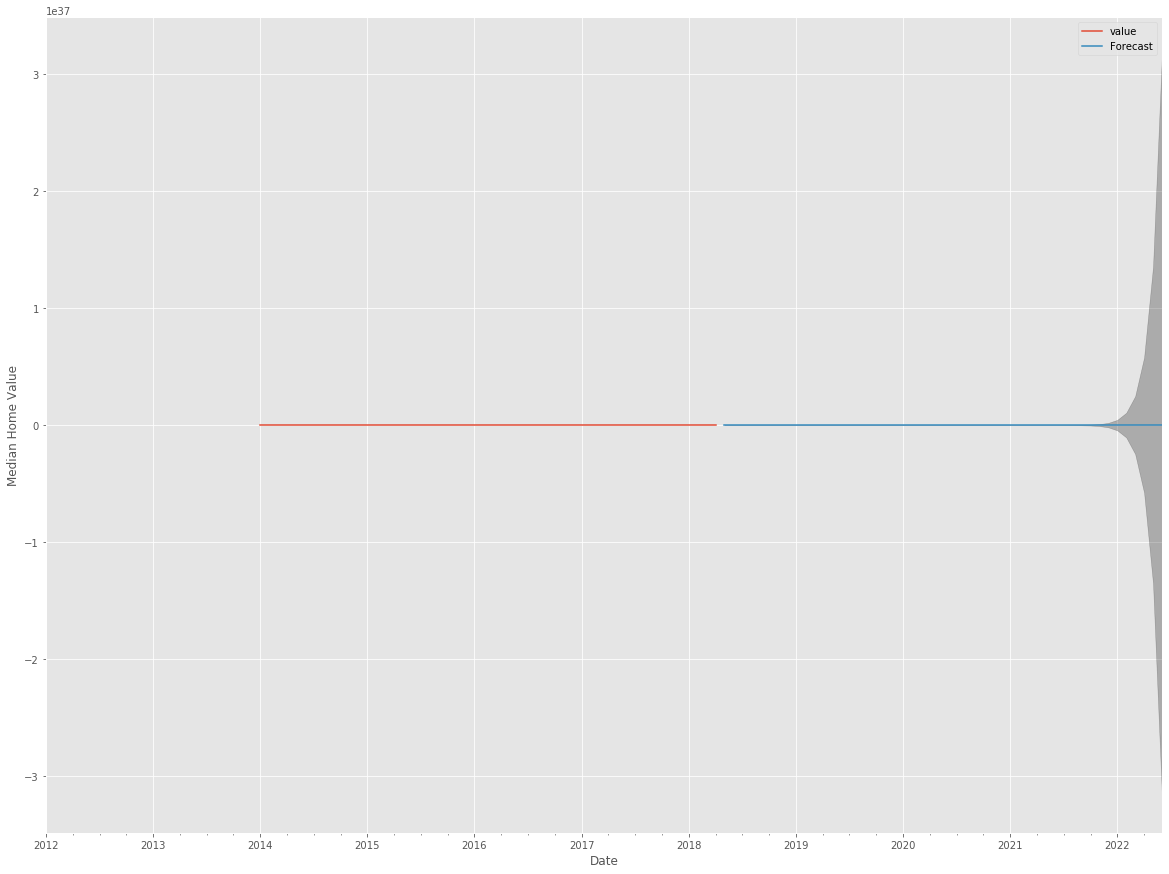

In [75]:
ax = two_three_six.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Median Home Value')

plt.legend()
plt.show()

### 11236 Conclusion: 

### 11218

In [76]:
two_one_eight = kings_grouped.loc[11218]

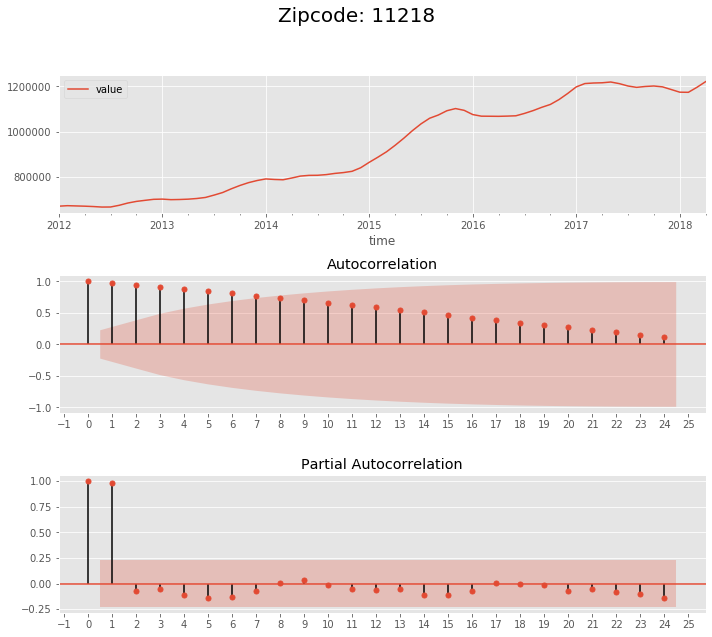

In [77]:
plot_acf_pacf(two_one_eight, zipcode = '11218')
plt.show()

### Decompose Time Series

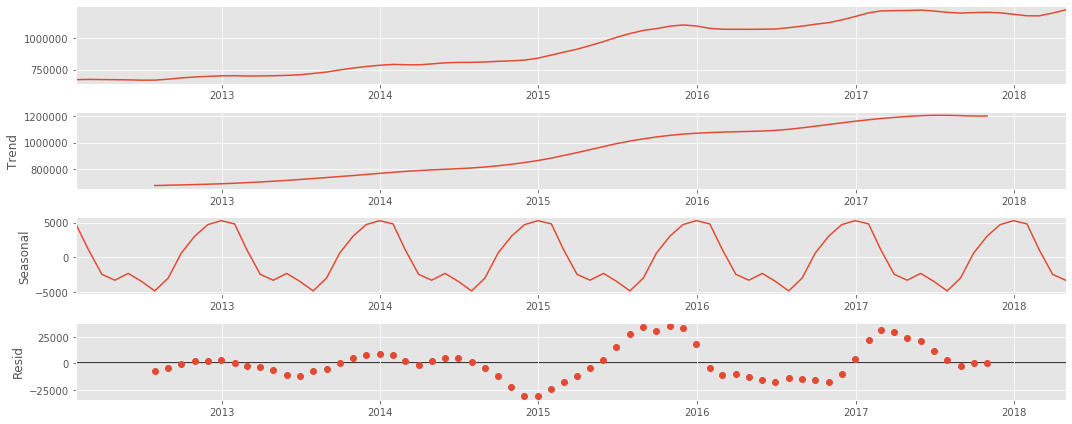

In [78]:
decompose_result = seasonal_decompose(two_one_eight, model="additive")

trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

decompose_result.plot();

### Fixing Trend: Moving Window Function (Mean Rolled)

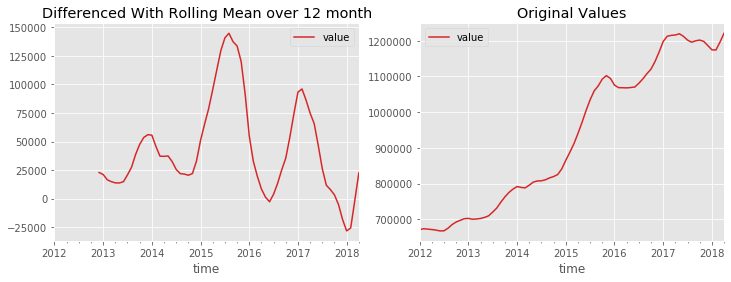

In [79]:
rolling_mean = two_one_eight.rolling(window = 12).mean()
two_one_eight_rolled_detrended = two_one_eight - rolling_mean

ax1 = plt.subplot(121)
two_one_eight_rolled_detrended.plot(figsize=(12,4),color="tab:red", title="Differenced With Rolling Mean over 12 month", ax=ax1);
ax2 = plt.subplot(122)
two_one_eight.plot(figsize=(12,4), color="tab:red", title="Original Values", ax=ax2);

### Testing with the Dicky-Fuller Test

Stationarity is not present.

In [80]:
dftest = adfuller(two_one_eight_rolled_detrended.dropna(), autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -1.1276887088156815
2. P-Value :  0.7039046293850986
3. Num Of Lags :  10
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 54
5. Critical Values :
	 1% :  -3.55770911573439
	 5% :  -2.9167703434435808
	 10% :  -2.59622219478738


### Using Differencing with Mean Rolled Time Series for Seasonality

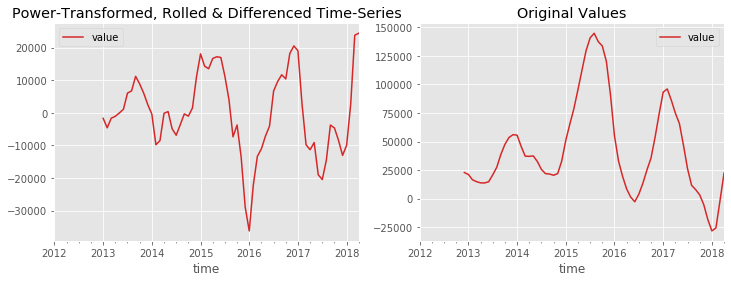

In [81]:
two_one_eight_rolled_detrended_diff = two_one_eight_rolled_detrended - two_one_eight_rolled_detrended.shift()

ax1 = plt.subplot(121)
two_one_eight_rolled_detrended_diff.plot(figsize=(8,4), color="tab:red", title="Power-Transformed, Rolled & Differenced Time-Series", ax=ax1);
ax2 = plt.subplot(122)
two_one_eight_rolled_detrended.plot(figsize=(12,4), color="tab:red", title="Original Values", ax=ax2);

In [82]:
two_one_eight = two_one_eight_rolled_detrended_diff

### Retesting with the Dicky-Fuller Test

Technically does not have stationarity.

In [83]:
dftest = adfuller(two_one_eight.dropna().values, autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -5.0561892250634175
2. P-Value :  1.71597177733296e-05
3. Num Of Lags :  9
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 54
5. Critical Values :
	 1% :  -3.55770911573439
	 5% :  -2.9167703434435808
	 10% :  -2.59622219478738


### Parameter Selection

In [84]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [85]:
# Run a grid with pdq and seasonal pdq parameters 
#calculated above and get the best (lowest) AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(two_one_eight, 
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            #print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

In [86]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (0, 1, 1)
pdqs    (1, 1, 1, 12)
aic           996.003
Name: 31, dtype: object

### Fitting the Time Series Model - ARIMA

COMMENTS ON THE P VALUES - LOW P VAL = GOOD 

In [87]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(two_one_eight, 
                                        order=(1, 1, 1), 
                                        seasonal_order=(1, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0467      1.592      0.029      0.977      -3.074       3.167
ma.L1          0.2993      1.465      0.204      0.838      -2.572       3.171
ar.S.L12      -0.5729      0.513     -1.116      0.264      -1.579       0.433
ma.S.L12      -1.0009      0.353     -2.836      0.005      -1.693      -0.309
sigma2      1.082e+08   4.18e-09   2.58e+16      0.000    1.08e+08    1.08e+08


### Plot Diagnostics

1. top-left: Seems like random noise more than seasonality. 
2. top-right: Seems to be normally distributed.
3. bottom-left: Mostly adheres to the line.
4. bottom right: Positive values may indicate a missed seasonal component.

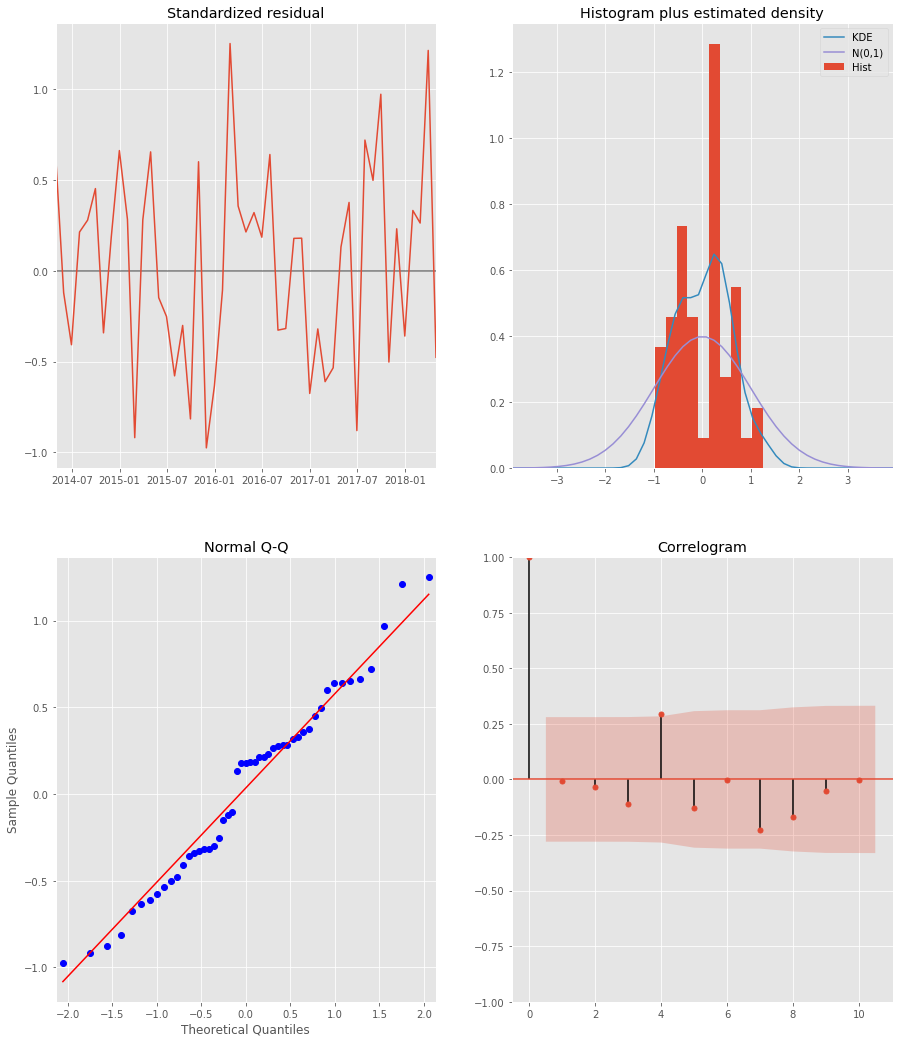

In [88]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

### Model Validation - One Step Ahead Forecasting:

The data can be split 80% and 20% by indicing at 2017-01-31.

In [89]:
pred = output.get_prediction(start=pd.to_datetime('2017-01-31'), dynamic=False)
pred_conf = pred.conf_int()

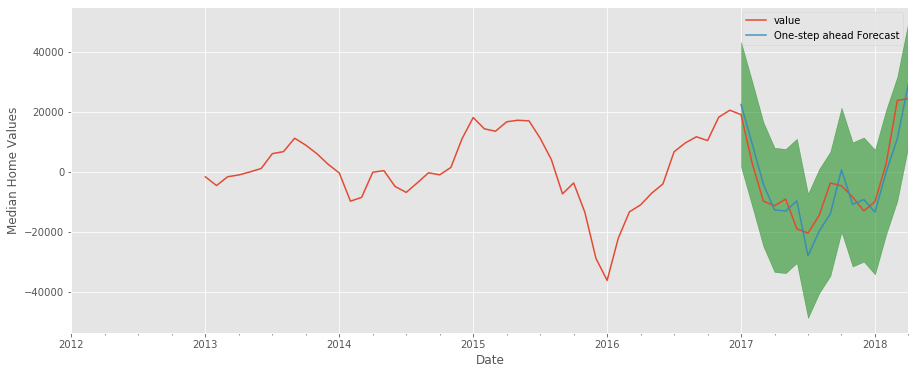

In [90]:

rcParams['figure.figsize'] = 15, 6

ax = two_one_eight['2012':].plot(label='observed')

pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

ax.set_xlabel('Date')
ax.set_ylabel('Median Home Values')
plt.legend()

plt.show()

### Accuracy Validation with MSE (Mean Squared Error)

In [91]:
val_forecasted = pred.predicted_mean
val_truth = two_one_eight.loc['2017-01-31':].value

mse = ((val_forecasted - val_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 39843797.29


### Model Validation - Dynamic Forecasting

In [92]:
pred_dynamic = output.get_prediction(start=pd.to_datetime('2017-01-31'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

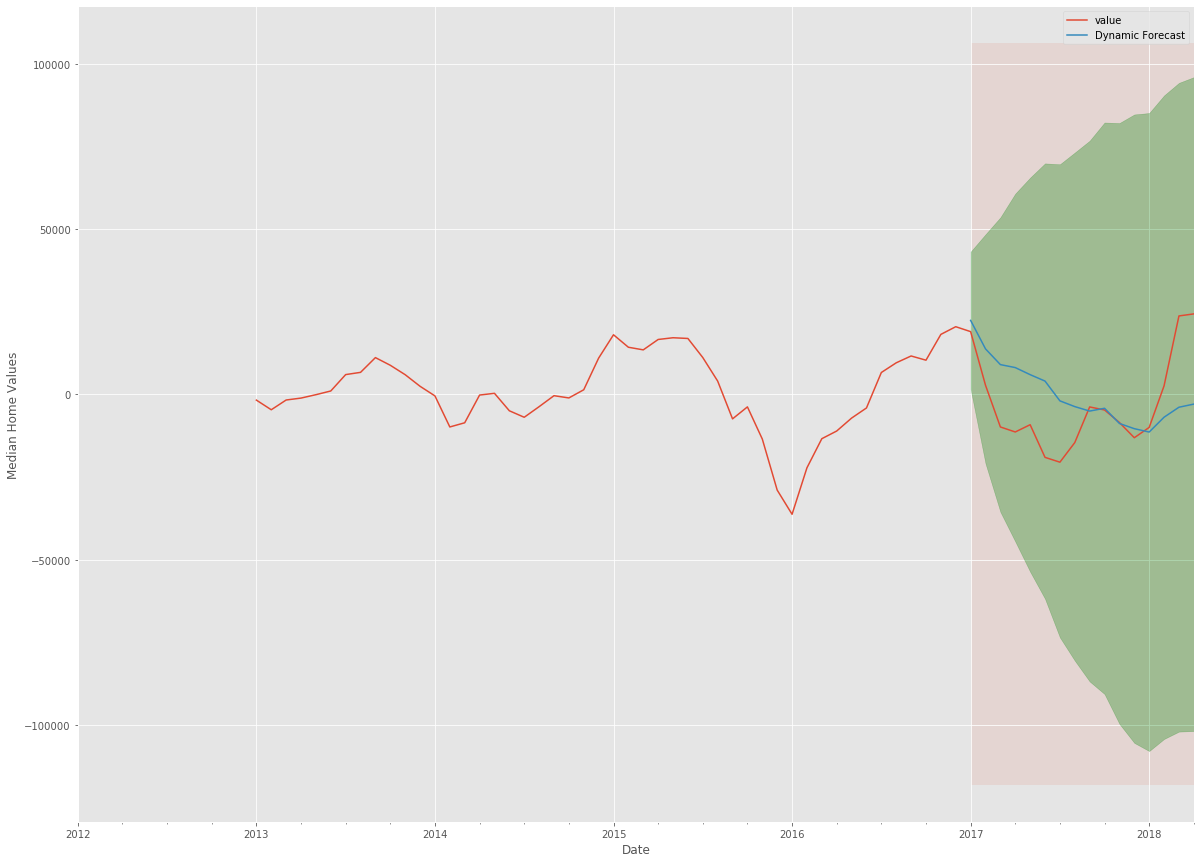

In [93]:
ax = two_one_eight['2012':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2017-01-31'), val_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Median Home Values')

plt.legend()
plt.show()


In [94]:
val_forecasted = pred_dynamic.predicted_mean
val_truth = two_one_eight.loc['2017-01-31':].value

mse = ((val_forecasted - val_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 231496104.95


### Visualizing Confidence Interval

In [95]:
# Get forecast 50 steps ahead in future
prediction = output.get_forecast(steps=50)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

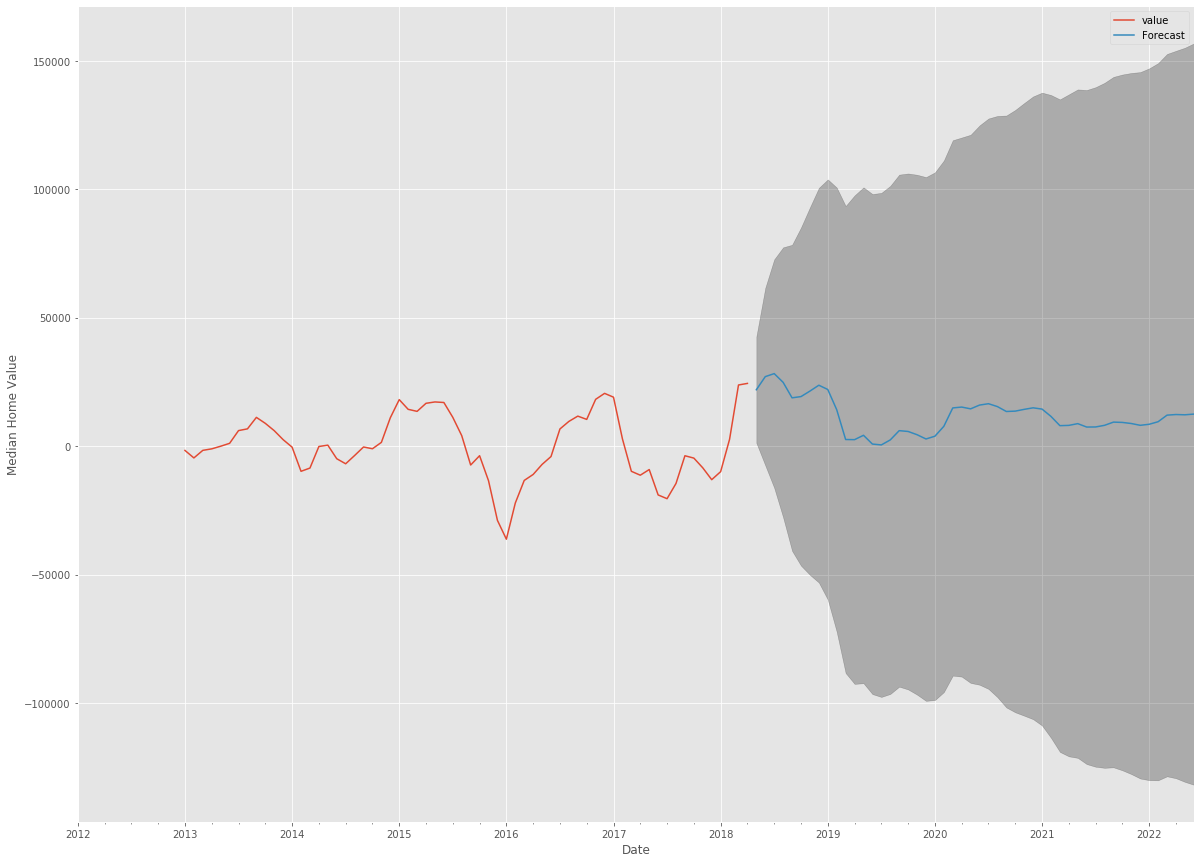

In [96]:
ax = two_one_eight.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Median Home Value')

plt.legend()
plt.show()

### 11218 Conclusion: 

### 11223

In [97]:
two_two_three = kings_grouped.loc[11223]

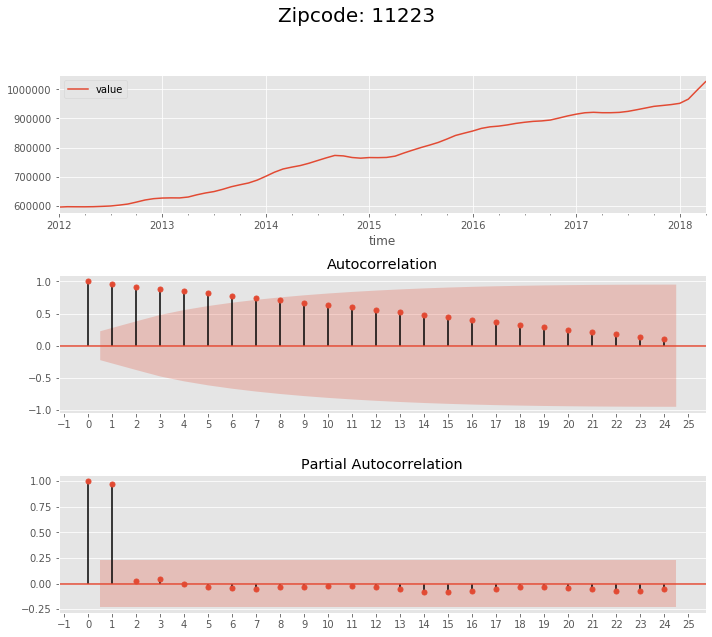

In [98]:
plot_acf_pacf(two_two_three, zipcode = '11223')
plt.show()

### Decompose Time Series

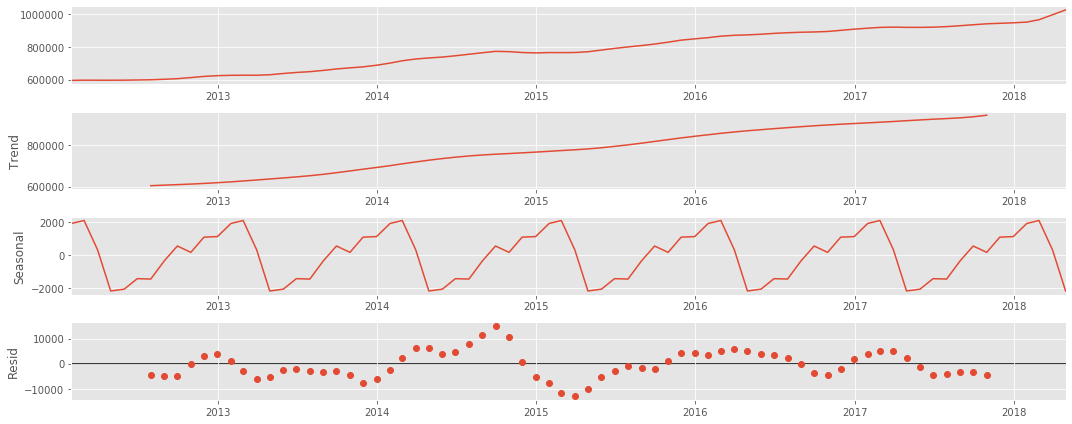

In [99]:
decompose_result = seasonal_decompose(two_two_three, model="additive")

trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

decompose_result.plot();

### Fixing Trend: Moving Window Function (Mean Rolled)

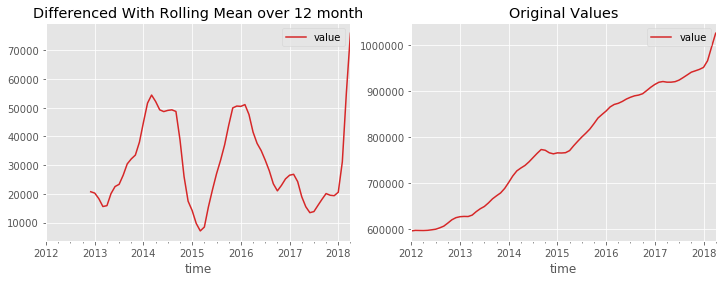

In [101]:
rolling_mean = two_two_three.rolling(window = 12).mean()
two_two_three_rolled_detrended = two_two_three - rolling_mean

ax1 = plt.subplot(121)
two_two_three_rolled_detrended.plot(figsize=(12,4),color="tab:red", title="Differenced With Rolling Mean over 12 month", ax=ax1);
ax2 = plt.subplot(122)
two_two_three.plot(figsize=(12,4), color="tab:red", title="Original Values", ax=ax2);

### Testing with the Dicky-Fuller Test

Stationarity is not present.

In [102]:
dftest = adfuller(two_two_three_rolled_detrended.dropna(), autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -3.337109340844451
2. P-Value :  0.013299012619458683
3. Num Of Lags :  3
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 61
5. Critical Values :
	 1% :  -3.542412746661615
	 5% :  -2.910236235808284
	 10% :  -2.5927445767266866


In [139]:
two_two_three = two_two_three_rolled_detrended.dropna()

### Retesting with the Dicky-Fuller Test

Technically does not have stationarity.

In [140]:
dftest = adfuller(two_two_three.dropna().values, autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -3.337109340844451
2. P-Value :  0.013299012619458683
3. Num Of Lags :  3
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 61
5. Critical Values :
	 1% :  -3.542412746661615
	 5% :  -2.910236235808284
	 10% :  -2.5927445767266866


### Parameter Selection

In [141]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [142]:
# Run a grid with pdq and seasonal pdq parameters 
#calculated above and get the best (lowest) AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(two_two_three, 
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            #print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

In [143]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic           741.554
Name: 59, dtype: object

### Fitting the Time Series Model - ARIMA

In [144]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(two_two_three, 
                                        order=(1, 1, 1), 
                                        seasonal_order=(0, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7315      0.206      3.553      0.000       0.328       1.135
ma.L1          0.6157      0.159      3.866      0.000       0.304       0.928
ma.S.L12      -0.5733      0.238     -2.407      0.016      -1.040      -0.106
sigma2      1.617e+07   2.55e-09   6.35e+15      0.000    1.62e+07    1.62e+07


### Plot Diagnostics

COMMENTS ON PLOT: 
1. top-left: Seems like random noise more than seasonality. 
2. top-right: Seems to be normally distributed.
3. bottom-left: Mostly adheres to the line.
4. bottom right: Positive values may indicate a missed seasonal component.

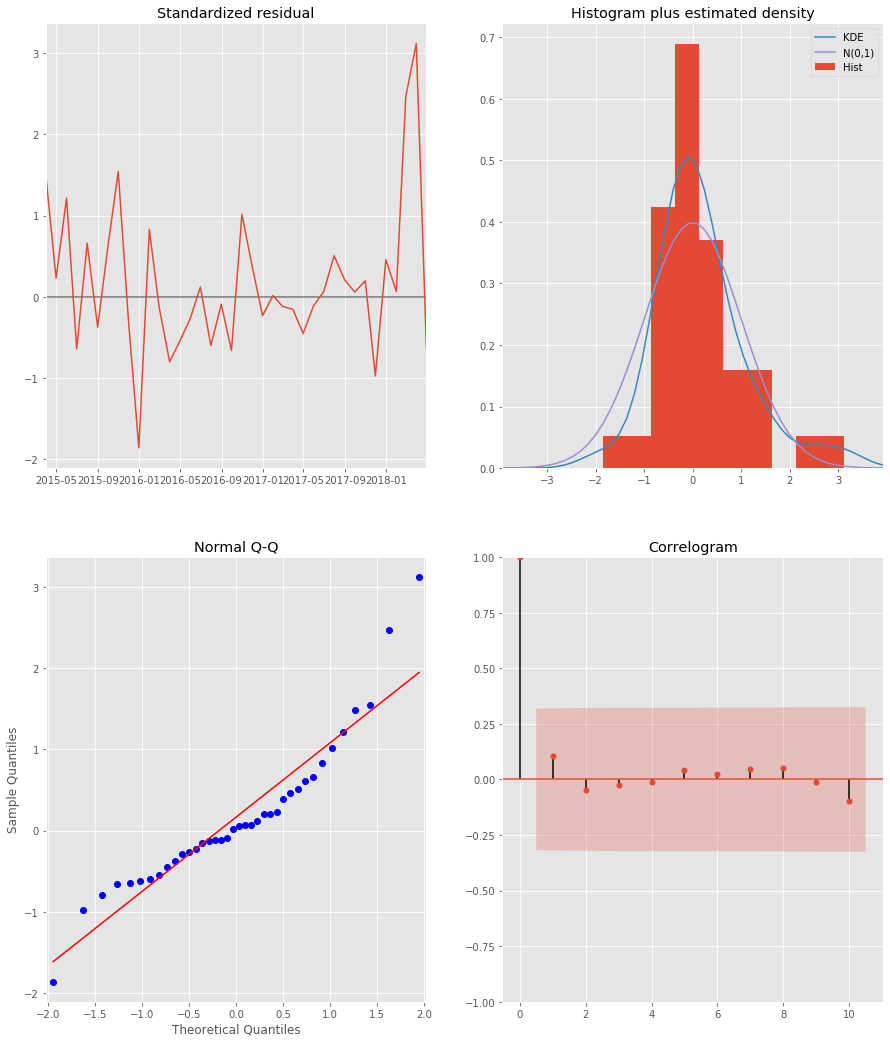

In [145]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

### Model Validation - One Step Ahead Forecasting:

The data can be split 80% and 20% by indicing at 2017-01-31.

In [146]:
pred = output.get_prediction(start=pd.to_datetime('2017-01-31'), dynamic=False)
pred_conf = pred.conf_int()

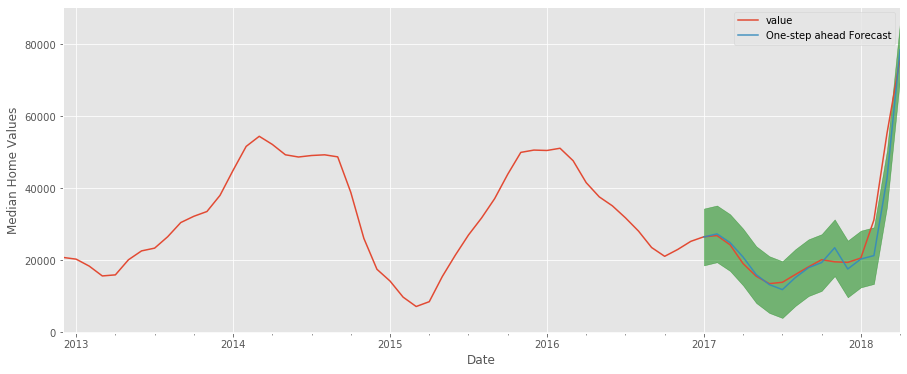

In [147]:

rcParams['figure.figsize'] = 15, 6

ax = two_two_three['2012':].plot(label='observed')

pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

ax.set_xlabel('Date')
ax.set_ylabel('Median Home Values')
plt.legend()

plt.show()

### Accuracy Validation with MSE (Mean Squared Error)

In [148]:
val_forecasted = pred.predicted_mean
val_truth = two_two_three.loc['2017-01-31':].value

mse = ((val_forecasted - val_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 18130161.19


### Model Validation - Dynamic Forecasting

In [149]:
pred_dynamic = output.get_prediction(start=pd.to_datetime('2017-01-31'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

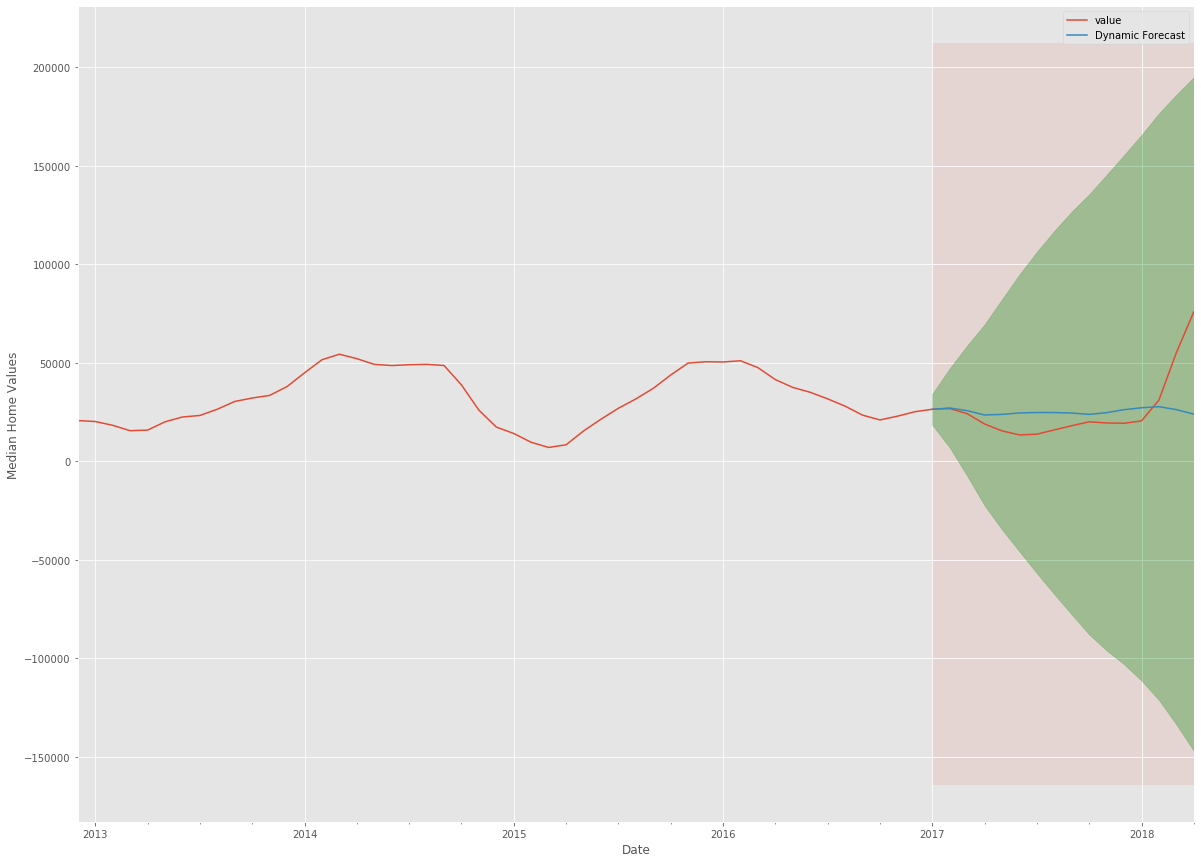

In [150]:
ax = two_two_three['2012':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2017-01-31'), val_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Median Home Values')

plt.legend()
plt.show()


In [151]:
val_forecasted = pred_dynamic.predicted_mean
val_truth = two_one_eight.loc['2017-01-31':].value

mse = ((val_forecasted - val_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 1001455759.27


### Visualizing Confidence Interval

In [152]:
# Get forecast 50 steps ahead in future
prediction = output.get_forecast(steps=50)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

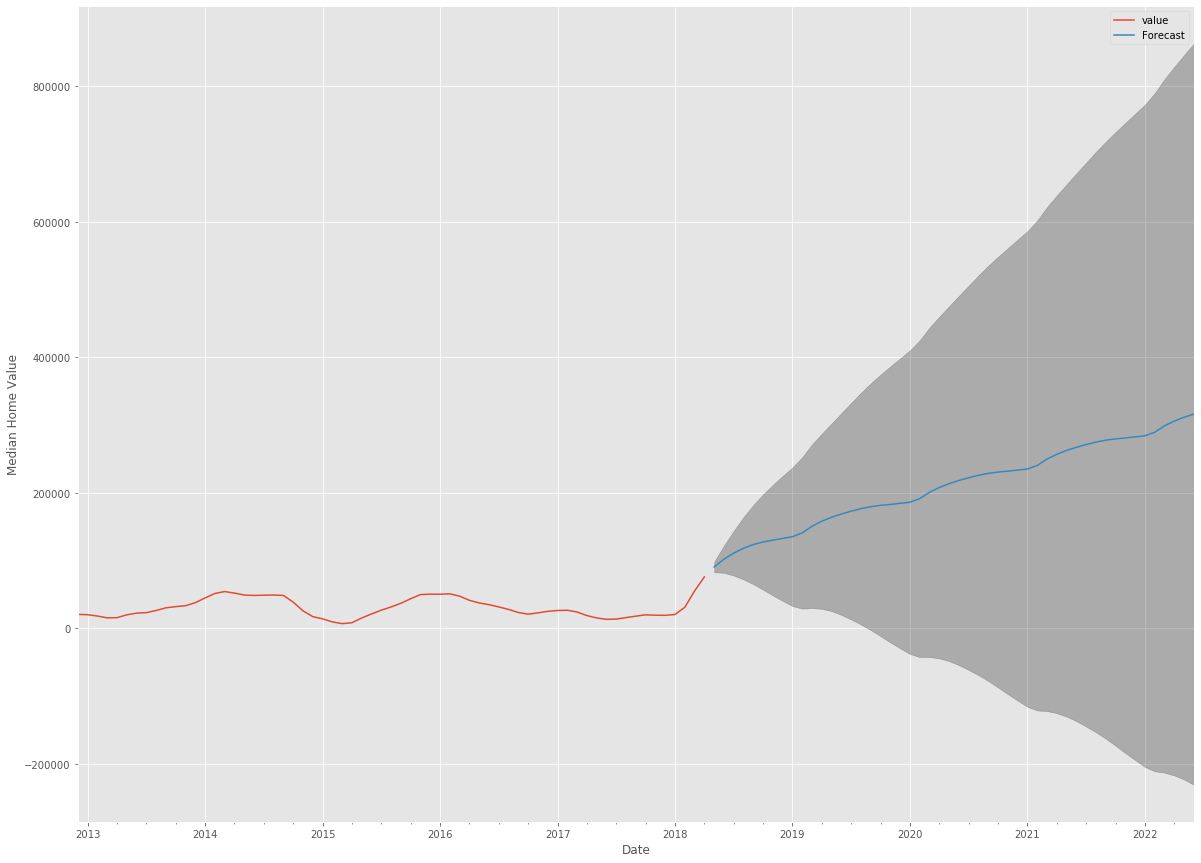

In [153]:
ax = two_two_three.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Median Home Value')

plt.legend()
plt.show()

### 11223 Conclusion: 

### 11208

In [154]:
two_zero_eight = kings_grouped.loc[11208]

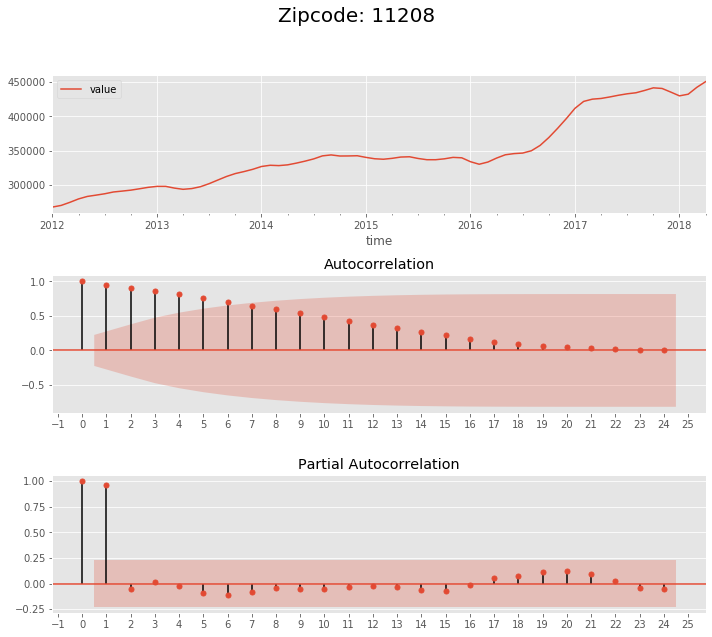

In [155]:
plot_acf_pacf(two_zero_eight, zipcode = '11208')
plt.show()

### Decompose Time Series

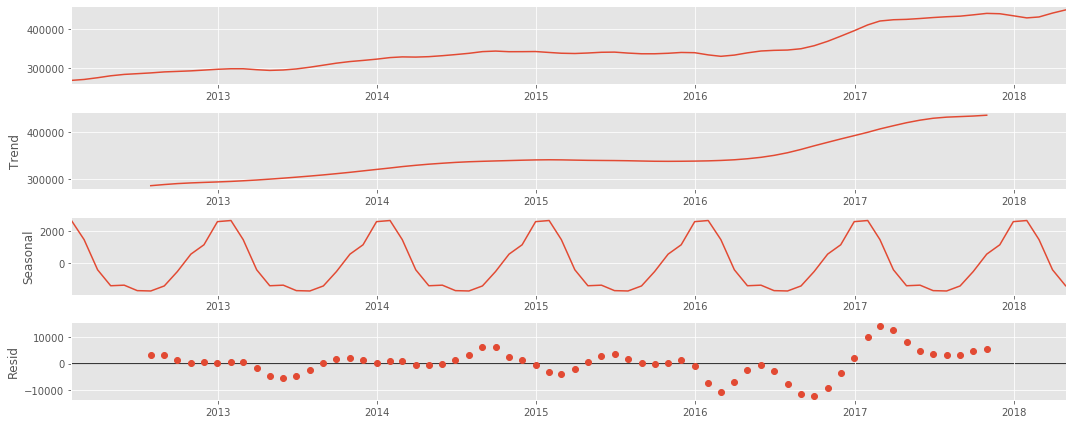

In [156]:
decompose_result = seasonal_decompose(two_zero_eight, model="additive")

trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

decompose_result.plot();

### Fixing Trend: Moving Window Function (Mean Rolled)

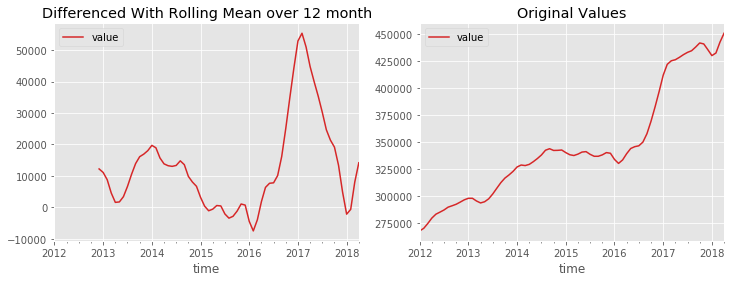

In [157]:
rolling_mean = two_zero_eight.rolling(window = 12).mean()
two_zero_eight_rolled_detrended = two_zero_eight - rolling_mean

ax1 = plt.subplot(121)
two_zero_eight_rolled_detrended.plot(figsize=(12,4),color="tab:red", title="Differenced With Rolling Mean over 12 month", ax=ax1);
ax2 = plt.subplot(122)
two_zero_eight.plot(figsize=(12,4), color="tab:red", title="Original Values", ax=ax2);

### Testing with the Dicky-Fuller Test

Stationarity is not present.

In [158]:
dftest = adfuller(two_zero_eight_rolled_detrended.dropna(), autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -2.8432645834003707
2. P-Value :  0.052354537275691615
3. Num Of Lags :  5
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 59
5. Critical Values :
	 1% :  -3.5463945337644063
	 5% :  -2.911939409384601
	 10% :  -2.5936515282964665


In [159]:
two_zero_eight = two_zero_eight_rolled_detrended


### Parameter Selection

In [160]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [161]:
# Run a grid with pdq and seasonal pdq parameters 
#calculated above and get the best (lowest) AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(two_zero_eight, 
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            #print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

In [162]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (1, 1, 1, 12)
aic           900.143
Name: 62, dtype: object

### Fitting the Time Series Model - ARIMA

In [163]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(two_zero_eight, 
                                        order=(1, 1, 1), 
                                        seasonal_order=(1, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6330      0.119      5.331      0.000       0.400       0.866
ma.L1          0.8084      0.110      7.381      0.000       0.594       1.023
ar.S.L12      -0.2931      0.172     -1.700      0.089      -0.631       0.045
ma.S.L12      -1.1940      0.629     -1.898      0.058      -2.427       0.039
sigma2      3.103e+06   2.51e+06      1.239      0.215   -1.81e+06    8.01e+06


### Plot Diagnostics

1. top-left: Seems like random noise more than seasonality. 
2. top-right: Seems to be normally distributed.
3. bottom-left: Mostly adheres to the line.
4. bottom right: Positive values may indicate a missed seasonal component.

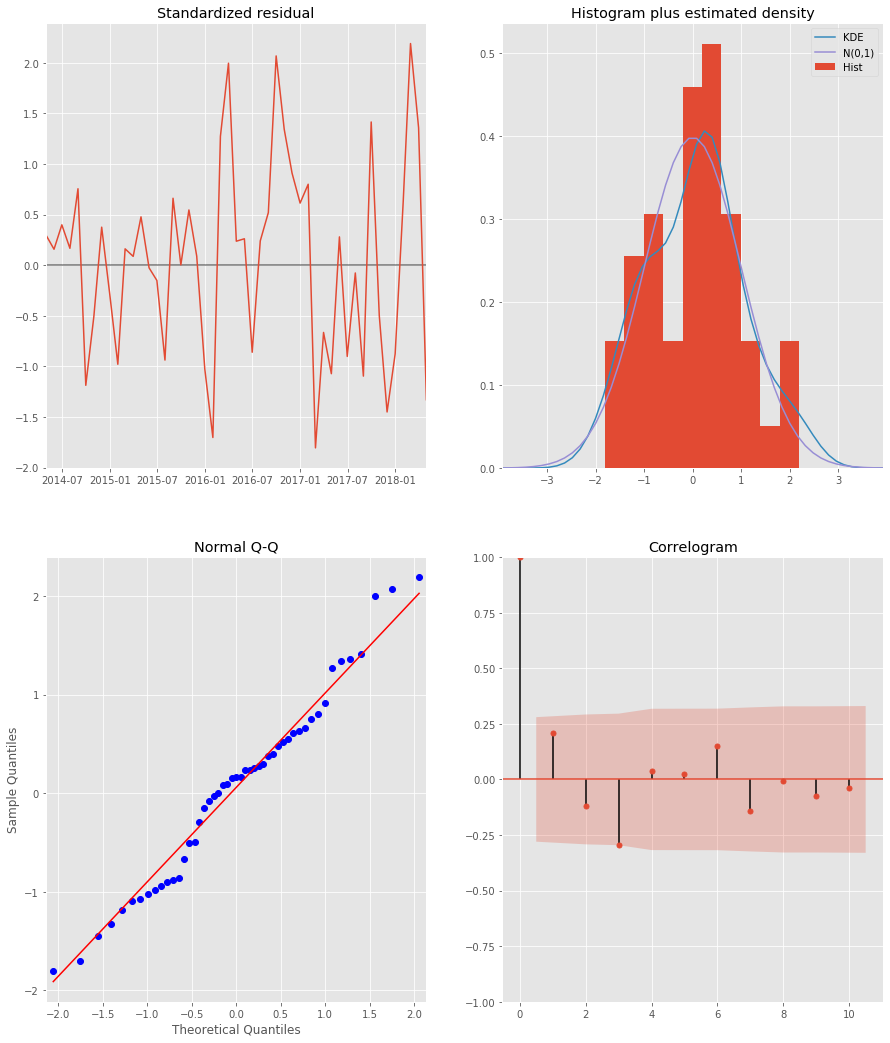

In [164]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

### Model Validation - One Step Ahead Forecasting:

The data can be split 80% and 20% by indicing at 2017-01-31.

In [165]:
pred = output.get_prediction(start=pd.to_datetime('2017-01-31'), dynamic=False)
pred_conf = pred.conf_int()

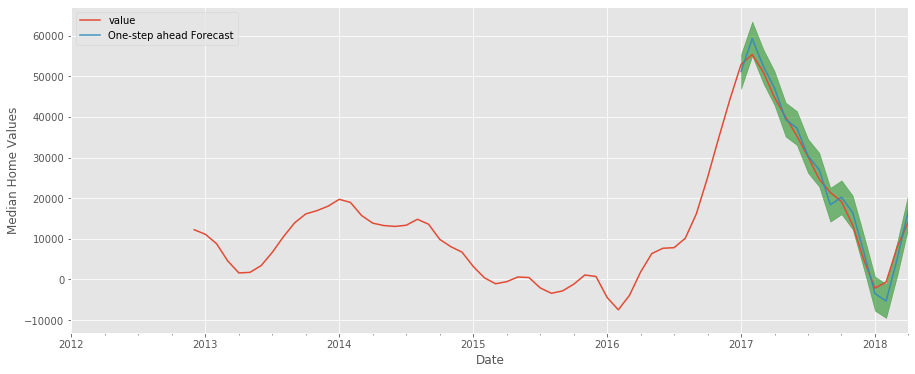

In [167]:

rcParams['figure.figsize'] = 15, 6

ax = two_zero_eight['2012':].plot(label='observed')

pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

ax.set_xlabel('Date')
ax.set_ylabel('Median Home Values')
plt.legend()

plt.show()

### Accuracy Validation with MSE (Mean Squared Error)

In [168]:
val_forecasted = pred.predicted_mean
val_truth = two_zero_eight.loc['2017-01-31':].value

mse = ((val_forecasted - val_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 6142104.63


### Model Validation - Dynamic Forecasting

In [169]:
pred_dynamic = output.get_prediction(start=pd.to_datetime('2017-01-31'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

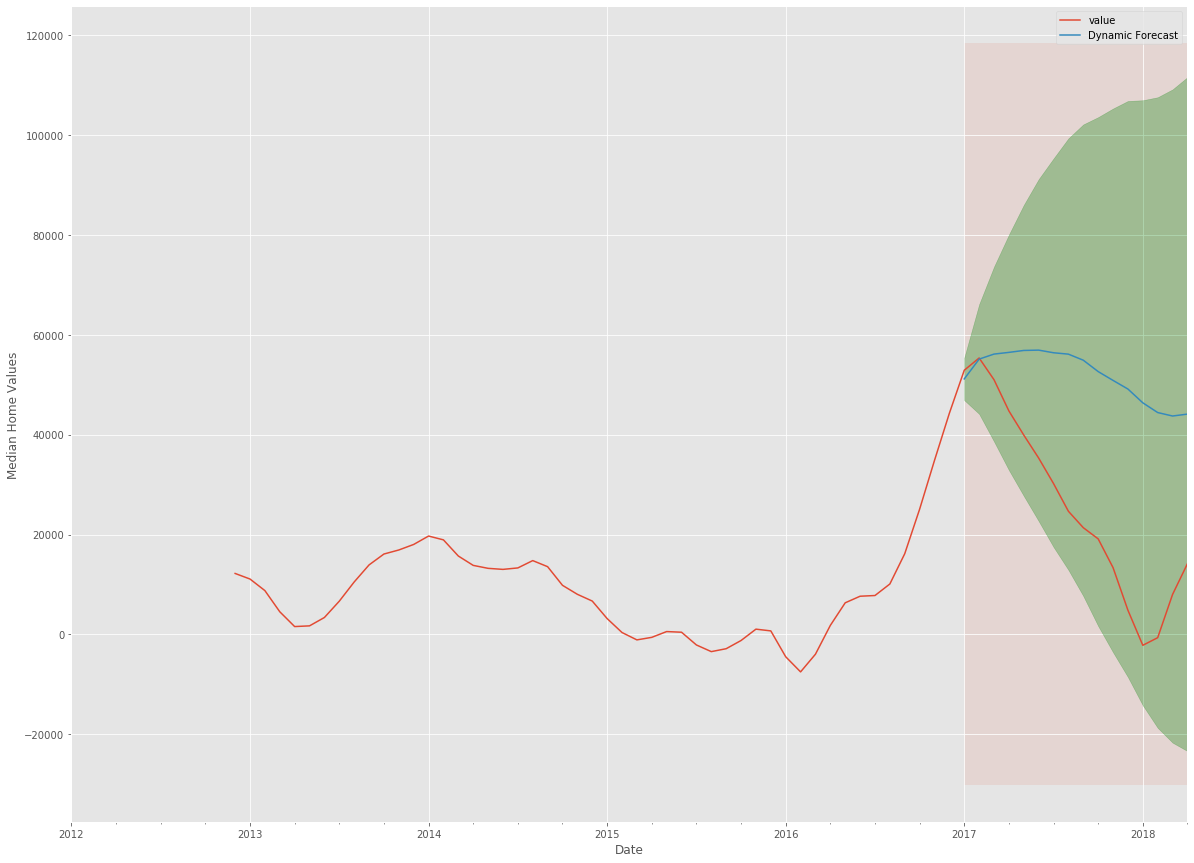

In [170]:
ax = two_zero_eight['2012':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2017-01-31'), val_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Median Home Values')

plt.legend()
plt.show()


In [171]:
val_forecasted = pred_dynamic.predicted_mean
val_truth = two_zero_eight.loc['2017-01-31':].value

mse = ((val_forecasted - val_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 923231947.28


### Visualizing Confidence Interval

In [172]:
# Get forecast 50 steps ahead in future
prediction = output.get_forecast(steps=50)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

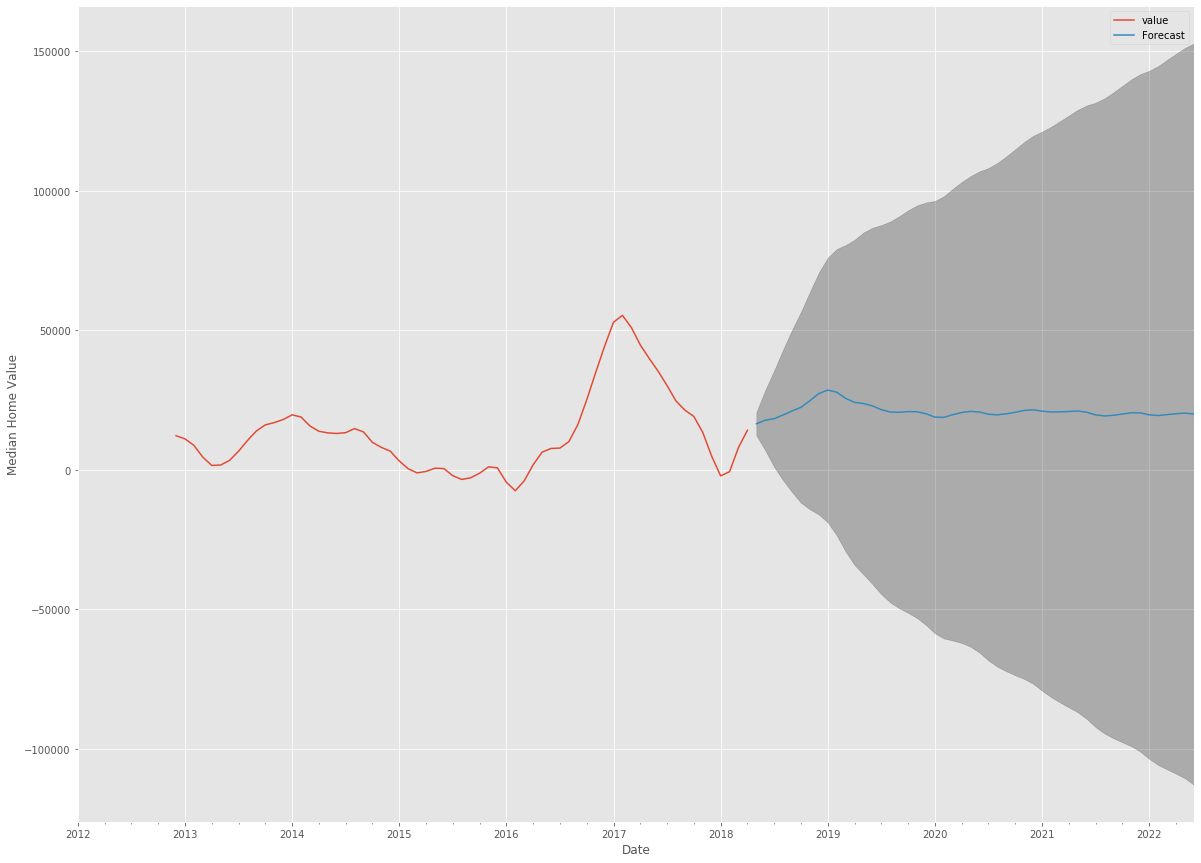

In [173]:
ax = two_zero_eight.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Median Home Value')

plt.legend()
plt.show()

### 11208 Conclusion: 

### 11204

In [174]:
two_zero_four = kings_grouped.loc[11204]

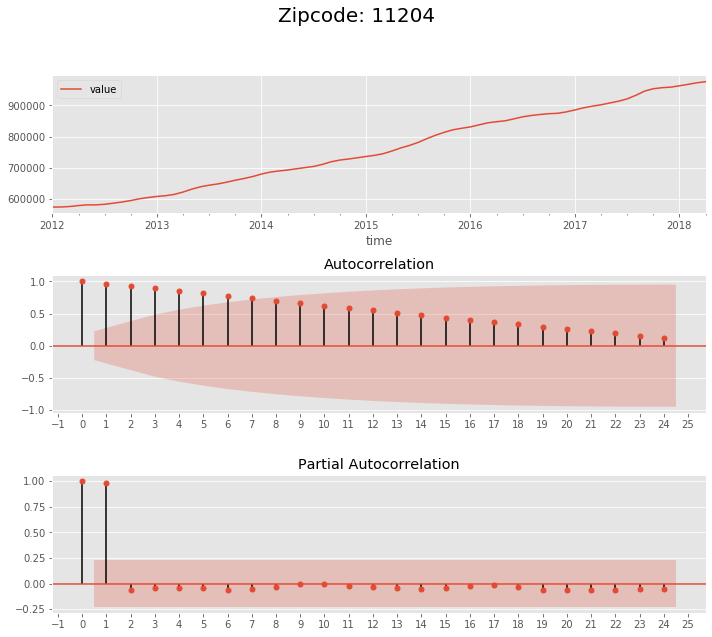

In [175]:
plot_acf_pacf(two_zero_four, zipcode = '11204')
plt.show()

### Decompose Time Series

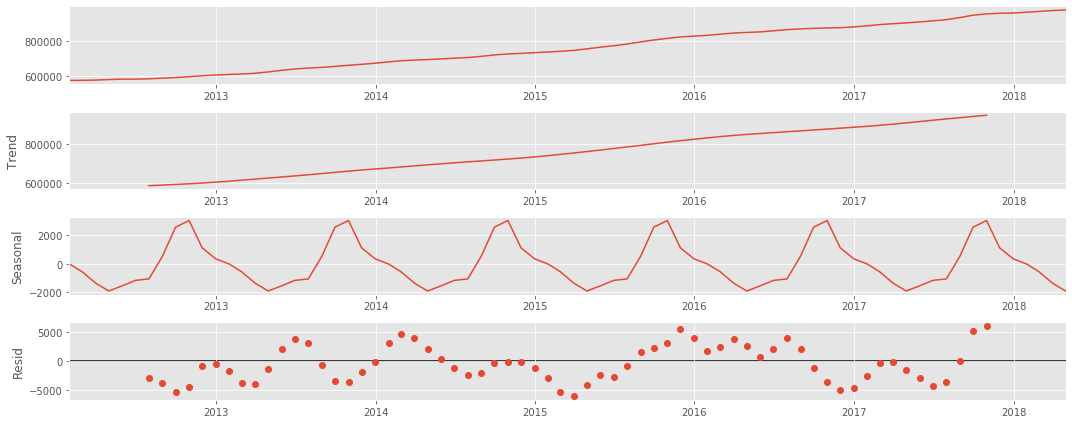

In [176]:
decompose_result = seasonal_decompose(two_zero_four, model="additive")

trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

decompose_result.plot();

### Fixing Trend: Moving Window Function (Mean Rolled)

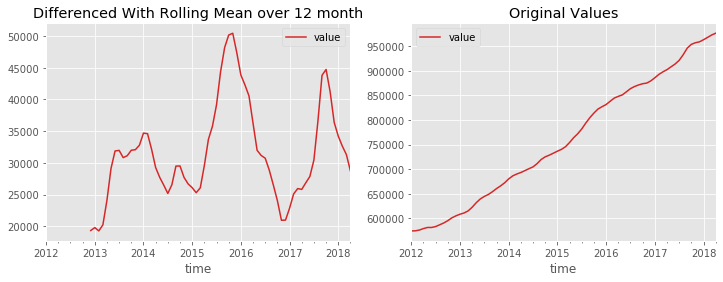

In [177]:
rolling_mean = two_zero_four.rolling(window = 12).mean()
two_zero_four_rolled_detrended = two_zero_four - rolling_mean

ax1 = plt.subplot(121)
two_zero_four_rolled_detrended.plot(figsize=(12,4),color="tab:red", title="Differenced With Rolling Mean over 12 month", ax=ax1);
ax2 = plt.subplot(122)
two_zero_four.plot(figsize=(12,4), color="tab:red", title="Original Values", ax=ax2);

### Testing with the Dicky-Fuller Test

Stationarity is not present.

In [178]:
dftest = adfuller(two_zero_four_rolled_detrended.dropna(), autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -3.7008495830587957
2. P-Value :  0.004101219850630526
3. Num Of Lags :  6
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 58
5. Critical Values :
	 1% :  -3.548493559596539
	 5% :  -2.912836594776334
	 10% :  -2.594129155766944


### Using Differencing with Mean Rolled Time Series for Seasonality

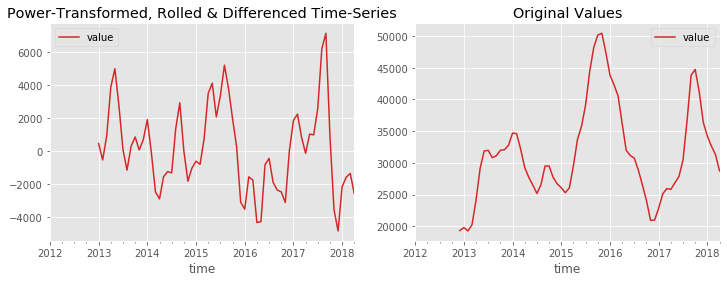

In [179]:
two_zero_four_rolled_detrended_diff = two_zero_four_rolled_detrended - two_zero_four_rolled_detrended.shift()

ax1 = plt.subplot(121)
two_zero_four_rolled_detrended_diff.plot(figsize=(8,4), color="tab:red", title="Power-Transformed, Rolled & Differenced Time-Series", ax=ax1);
ax2 = plt.subplot(122)
two_zero_four_rolled_detrended.plot(figsize=(12,4), color="tab:red", title="Original Values", ax=ax2);

In [180]:
two_zero_four = two_zero_four_rolled_detrended_diff

### Retesting with the Dicky-Fuller Test

Technically does not have stationarity.

In [182]:
dftest = adfuller(two_zero_four.dropna().values, autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -2.850990939059057
2. P-Value :  0.051351120391837625
3. Num Of Lags :  6
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 57
5. Critical Values :
	 1% :  -3.5506699942762414
	 5% :  -2.913766394626147
	 10% :  -2.5946240473991997


### Parameter Selection

In [183]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [184]:
# Run a grid with pdq and seasonal pdq parameters 
#calculated above and get the best (lowest) AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(two_zero_four, 
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            #print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

In [185]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (0, 1, 1)
pdqs    (1, 1, 1, 12)
aic            876.28
Name: 31, dtype: object

### Fitting the Time Series Model - ARIMA

COMMENTS ON THE P VALUES - LOW P VAL = GOOD 

In [186]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(two_zero_four, 
                                        order=(0, 1, 1), 
                                        seasonal_order=(1, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.6417      0.150      4.289      0.000       0.349       0.935
ar.S.L12      -0.4174      0.223     -1.872      0.061      -0.854       0.020
ma.S.L12      -1.3772      0.636     -2.166      0.030      -2.623      -0.131
sigma2      1.431e+06   1.22e+06      1.173      0.241    -9.6e+05    3.82e+06


### Plot Diagnostics

COMMENTS ON PLOT: 
1. top-left: Seems like random noise more than seasonality. 
2. top-right: Seems to be normally distributed.
3. bottom-left: Mostly adheres to the line.
4. bottom right: Positive values may indicate a missed seasonal component.

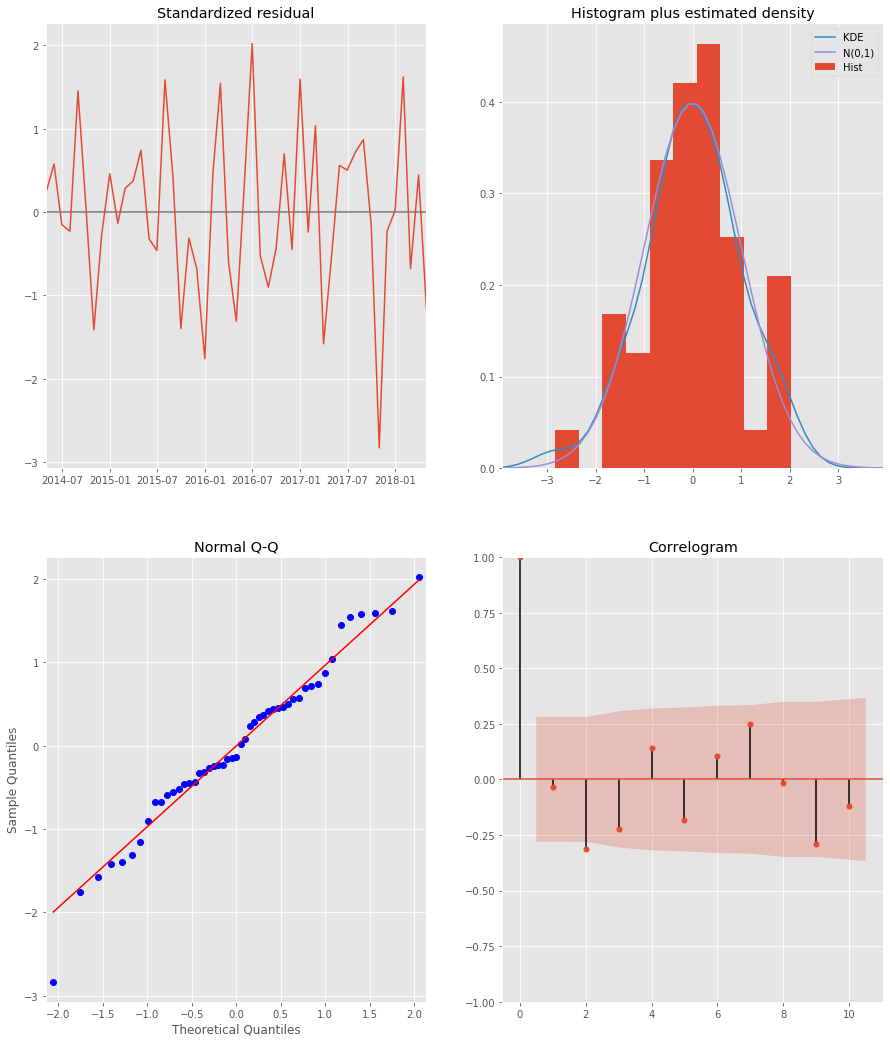

In [187]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

### Model Validation - One Step Ahead Forecasting:

The data can be split 80% and 20% by indicing at 2017-01-31.

In [188]:
pred = output.get_prediction(start=pd.to_datetime('2017-01-31'), dynamic=False)
pred_conf = pred.conf_int()

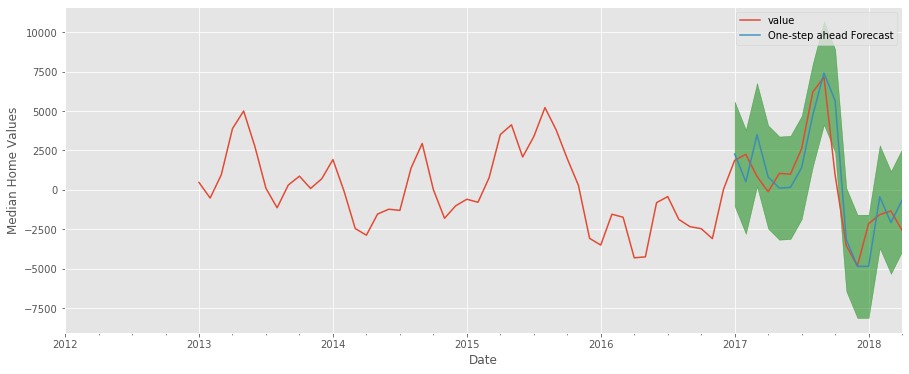

In [189]:

rcParams['figure.figsize'] = 15, 6

ax = two_zero_four['2012':].plot(label='observed')

pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

ax.set_xlabel('Date')
ax.set_ylabel('Median Home Values')
plt.legend()

plt.show()

### Accuracy Validation with MSE (Mean Squared Error)

In [190]:
val_forecasted = pred.predicted_mean
val_truth = two_zero_four.loc['2017-01-31':].value

mse = ((val_forecasted - val_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 3224363.75


### Model Validation - Dynamic Forecasting

In [191]:
pred_dynamic = output.get_prediction(start=pd.to_datetime('2017-01-31'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

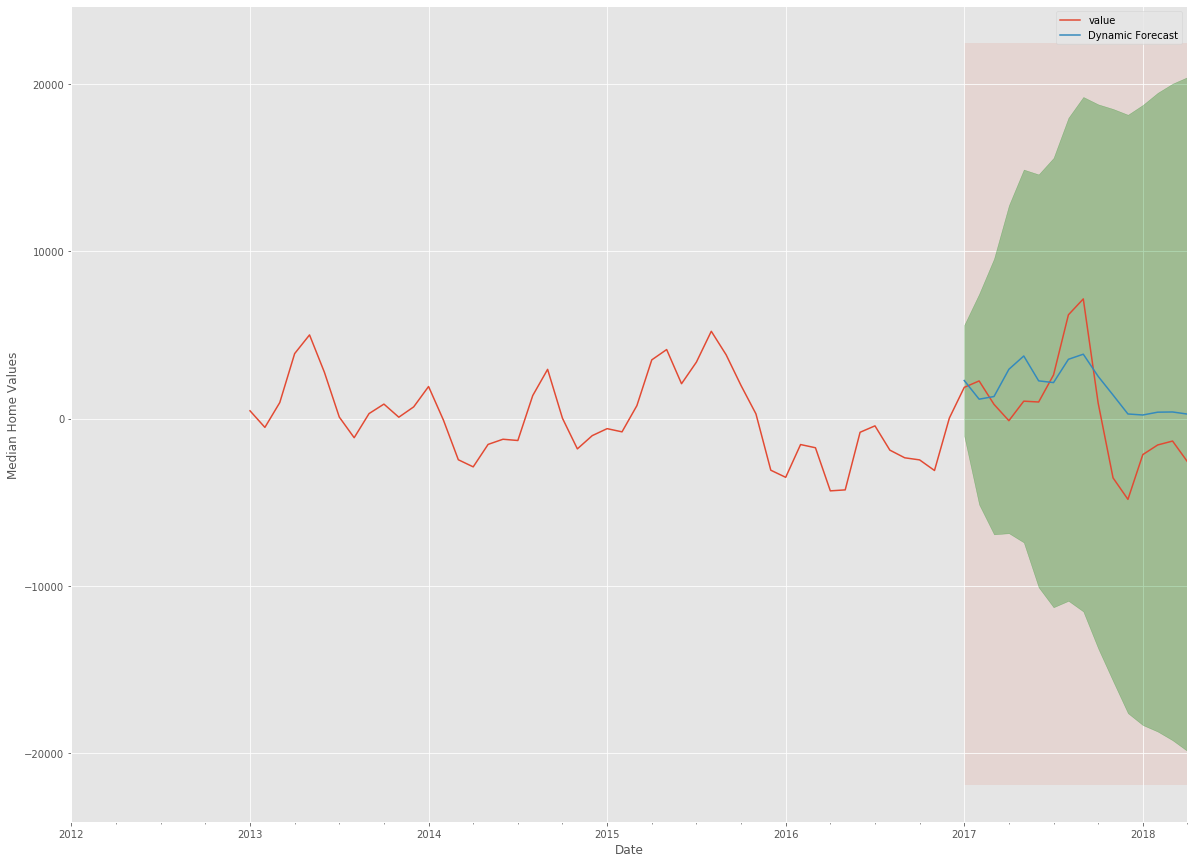

In [192]:
ax = two_zero_four['2012':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2017-01-31'), val_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Median Home Values')

plt.legend()
plt.show()


In [193]:
val_forecasted = pred_dynamic.predicted_mean
val_truth = two_zero_four.loc['2017-01-31':].value

mse = ((val_forecasted - val_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 6979580.88


### Visualizing Confidence Interval

In [194]:
# Get forecast 50 steps ahead in future
prediction = output.get_forecast(steps=50)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

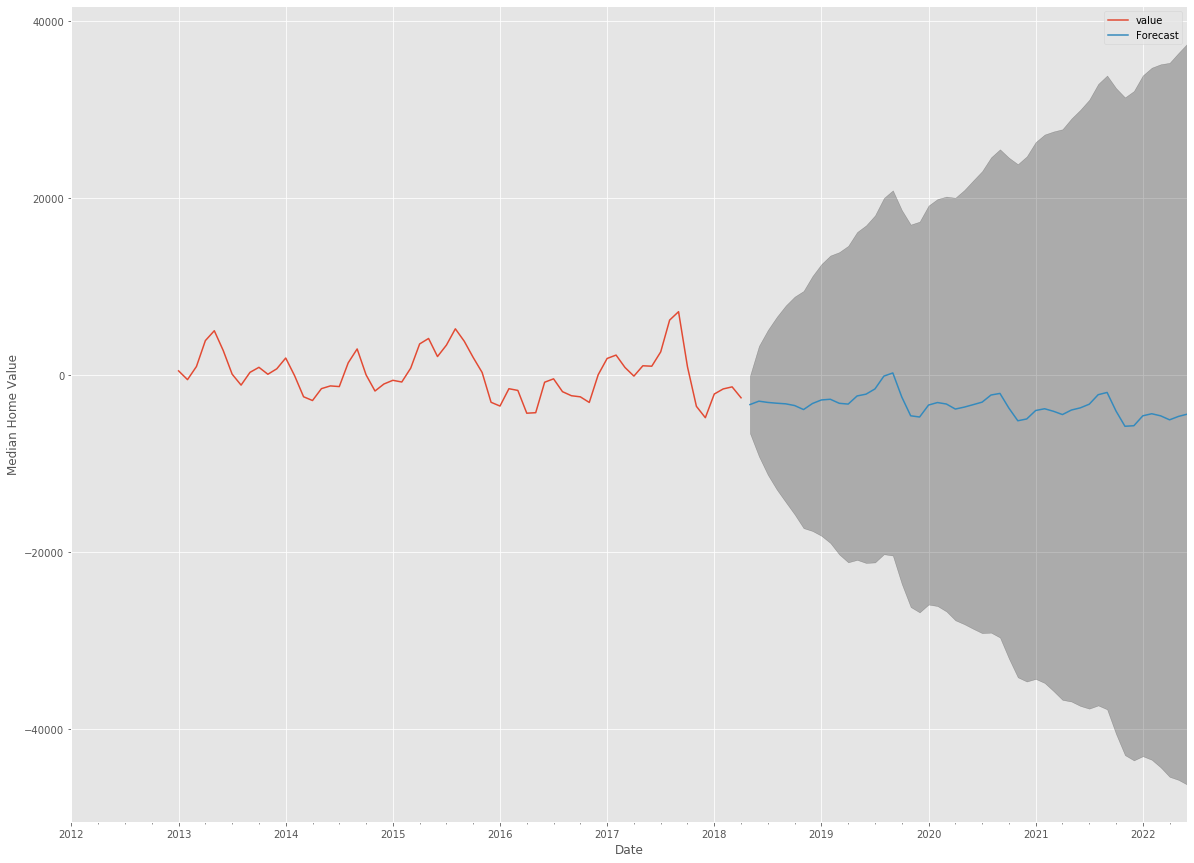

In [195]:
ax = two_zero_four.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Median Home Value')

plt.legend()
plt.show()

### 11204 Conclusion: 

### 11219

In [196]:
two_one_nine = kings_grouped.loc[11219]

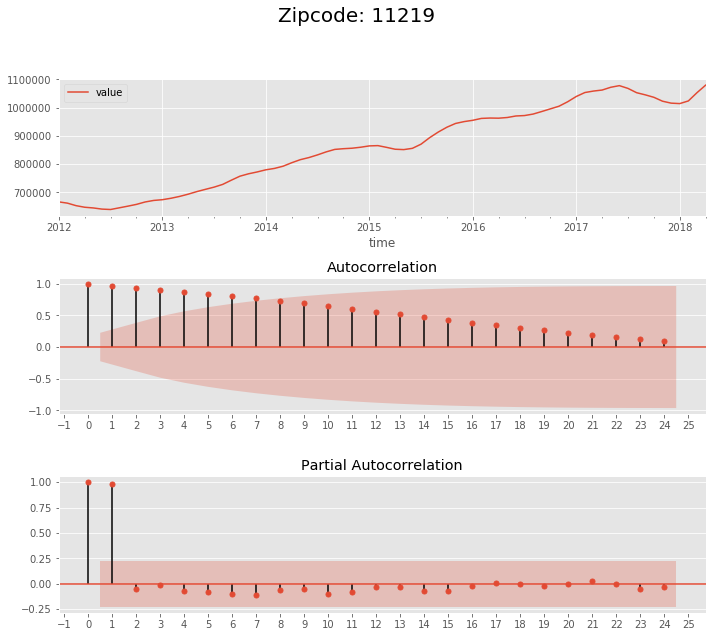

In [197]:
plot_acf_pacf(two_one_nine, zipcode = '11219')
plt.show()

### Decompose Time Series

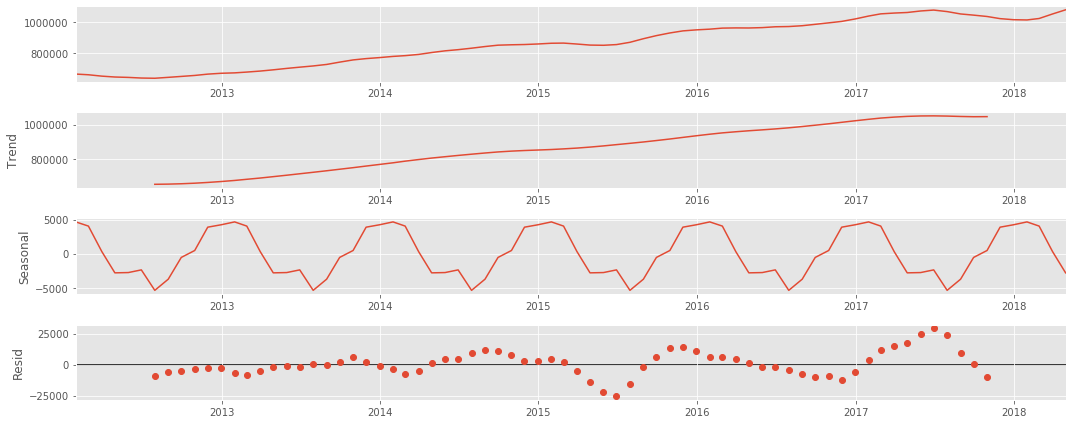

In [198]:
decompose_result = seasonal_decompose(two_one_nine, model="additive")

trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

decompose_result.plot();

### Fixing Trend: Moving Window Function (Mean Rolled)

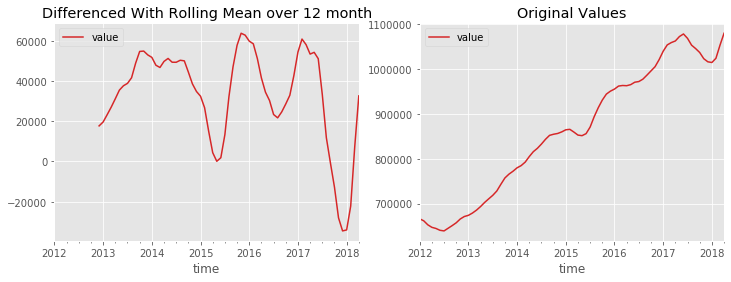

In [199]:
rolling_mean = two_one_nine.rolling(window = 12).mean()
two_one_nine_rolled_detrended = two_one_nine - rolling_mean

ax1 = plt.subplot(121)
two_one_nine_rolled_detrended.plot(figsize=(12,4),color="tab:red", title="Differenced With Rolling Mean over 12 month", ax=ax1);
ax2 = plt.subplot(122)
two_one_nine.plot(figsize=(12,4), color="tab:red", title="Original Values", ax=ax2);

### Testing with the Dicky-Fuller Test

Stationarity is not present.

In [200]:
dftest = adfuller(two_one_nine_rolled_detrended.dropna(), autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -1.2577587375598769
2. P-Value :  0.6482695131737274
3. Num Of Lags :  9
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 55
5. Critical Values :
	 1% :  -3.5552728880540942
	 5% :  -2.9157312396694217
	 10% :  -2.5956695041322315


### Using Differencing with Mean Rolled Time Series for Seasonality

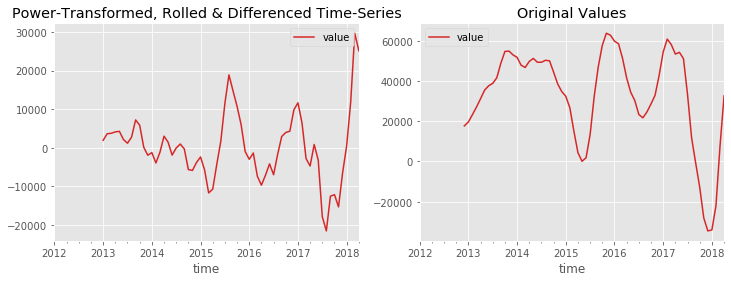

In [201]:
two_one_nine_rolled_detrended_diff = two_one_nine_rolled_detrended - two_one_nine_rolled_detrended.shift()

ax1 = plt.subplot(121)
two_one_nine_rolled_detrended_diff.plot(figsize=(8,4), color="tab:red", title="Power-Transformed, Rolled & Differenced Time-Series", ax=ax1);
ax2 = plt.subplot(122)
two_one_nine_rolled_detrended.plot(figsize=(12,4), color="tab:red", title="Original Values", ax=ax2);

In [202]:
two_one_nine = two_one_nine_rolled_detrended_diff

### Retesting with the Dicky-Fuller Test

Technically does not have stationarity.

In [204]:
dftest = adfuller(two_one_nine.dropna().values, autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -4.512057719421042
2. P-Value :  0.0001870069800917913
3. Num Of Lags :  8
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 55
5. Critical Values :
	 1% :  -3.5552728880540942
	 5% :  -2.9157312396694217
	 10% :  -2.5956695041322315


### Parameter Selection

In [205]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [206]:
# Run a grid with pdq and seasonal pdq parameters 
#calculated above and get the best (lowest) AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(two_one_nine, 
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            #print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

In [207]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (0, 1, 1)
pdqs    (0, 1, 1, 12)
aic           985.231
Name: 27, dtype: object

### Fitting the Time Series Model - ARIMA

COMMENTS ON THE P VALUES - LOW P VAL = GOOD 

In [210]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(two_one_nine, 
                                        order=(0, 1, 1), 
                                        seasonal_order=(0, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.6733      0.212      3.180      0.001       0.258       1.088
ma.S.L12      -1.0702      0.233     -4.590      0.000      -1.527      -0.613
sigma2       3.84e+07   3.01e-09   1.27e+16      0.000    3.84e+07    3.84e+07


### Plot Diagnostics

COMMENTS ON PLOT: 
1. top-left: Seems like random noise more than seasonality. 
2. top-right: Seems to be normally distributed.
3. bottom-left: Mostly adheres to the line.
4. bottom right: Positive values may indicate a missed seasonal component.

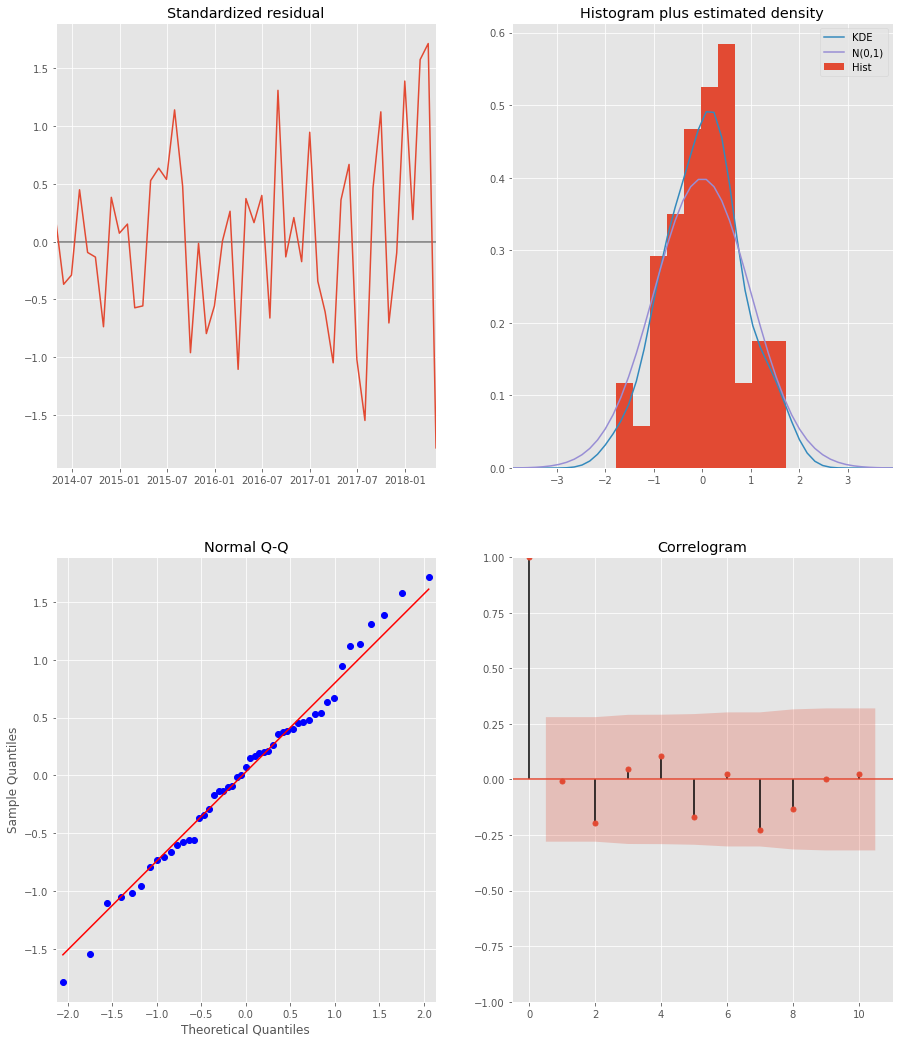

In [211]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

### Model Validation - One Step Ahead Forecasting:

The data can be split 80% and 20% by indicing at 2017-01-31.

In [212]:
pred = output.get_prediction(start=pd.to_datetime('2017-01-31'), dynamic=False)
pred_conf = pred.conf_int()

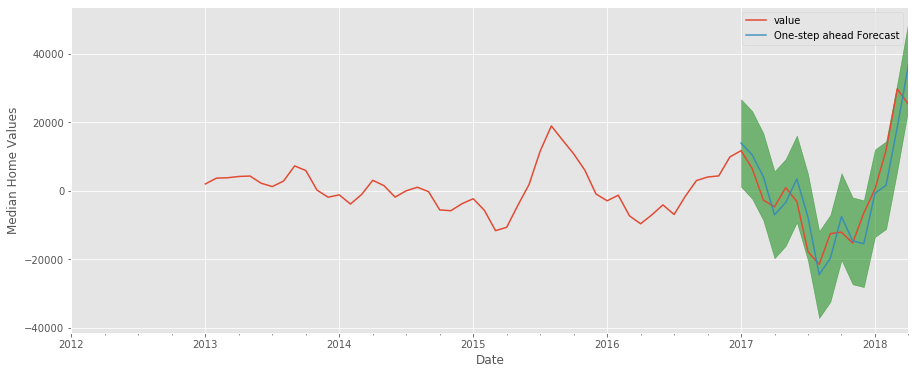

In [213]:

rcParams['figure.figsize'] = 15, 6

ax = two_one_nine['2012':].plot(label='observed')

pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

ax.set_xlabel('Date')
ax.set_ylabel('Median Home Values')
plt.legend()

plt.show()

### Accuracy Validation with MSE (Mean Squared Error)

In [214]:
val_forecasted = pred.predicted_mean
val_truth = two_one_nine.loc['2017-01-31':].value

mse = ((val_forecasted - val_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 47599836.98


### Model Validation - Dynamic Forecasting

In [215]:
pred_dynamic = output.get_prediction(start=pd.to_datetime('2017-01-31'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

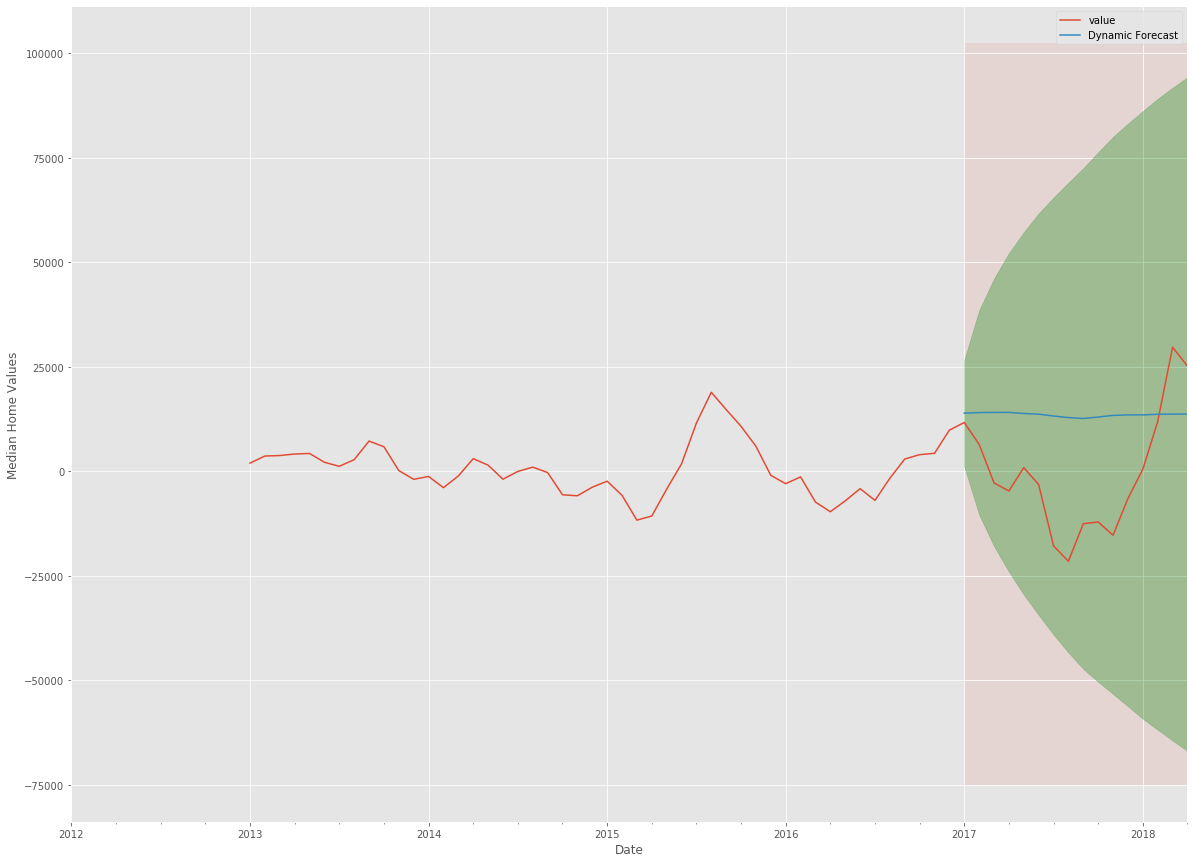

In [216]:
ax = two_one_nine['2012':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2017-01-31'), val_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Median Home Values')

plt.legend()
plt.show()


In [217]:
val_forecasted = pred_dynamic.predicted_mean
val_truth = two_one_nine.loc['2017-01-31':].value

mse = ((val_forecasted - val_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 396277532.91


### Visualizing Confidence Interval

In [218]:
# Get forecast 50 steps ahead in future
prediction = output.get_forecast(steps=50)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

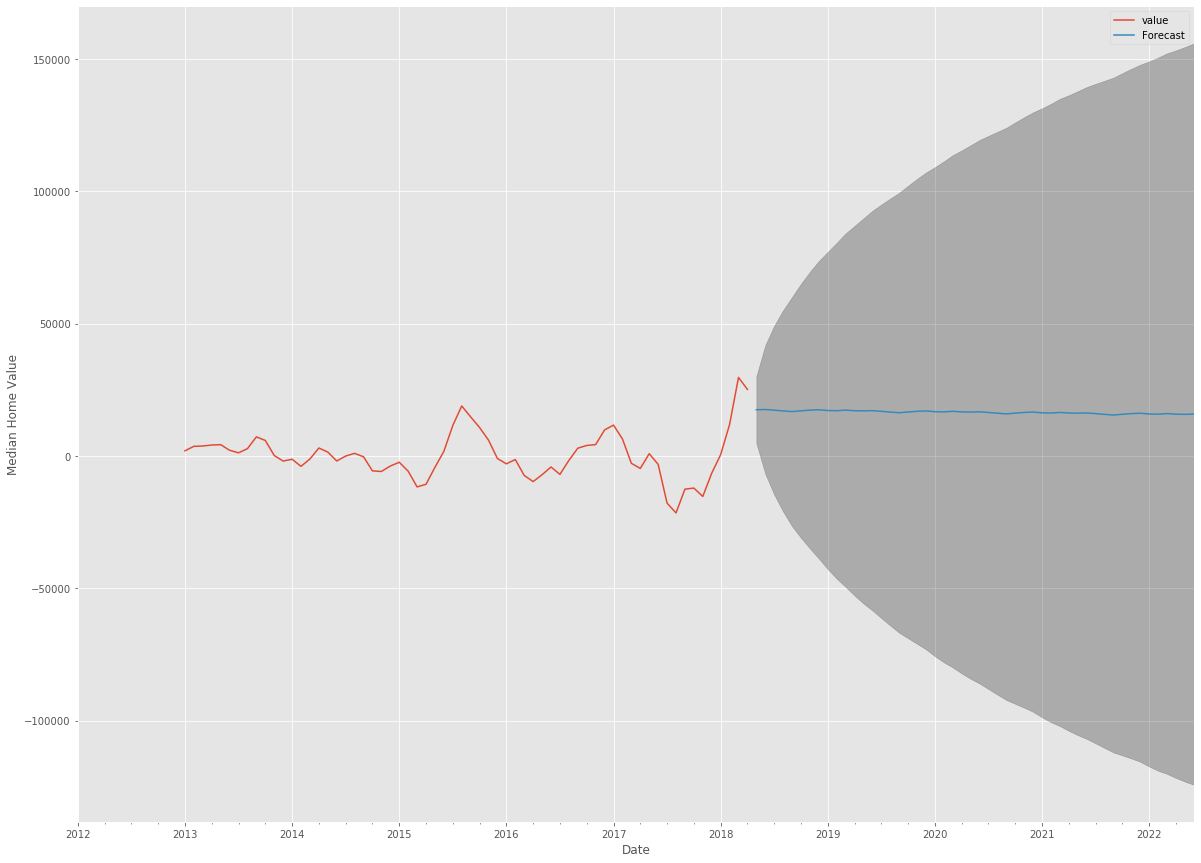

In [219]:
ax = two_one_nine.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Median Home Value')

plt.legend()
plt.show()

### 11219 Conclusion: 